# Physics 305 Final Project

- Rene L. Principe Jr.
- 2015-04622

## Importing Libraries

In [1]:
from tqdm import tqdm
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

from scipy.stats import norm, describe
from scipy.optimize import curve_fit

import math

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Functions

In [2]:
def get_sample_dx(x, delta):
    x_trunc = x[:-1*delta]
    x_shift = x[delta:]
    dx = x_shift - x_trunc
    return dx

def get_pdf(x, delta, bin_edges, norm=True):
    dx = get_sample_dx(x, delta)
    pdf, junk = np.histogram(dx, bins = bin_edges, density=norm)
    return pdf

def gaussian(x, sigma2, N):
    fac = N/(2.*np.pi*sigma2)**0.5
    return fac*np.exp(-1.*(x)**2/2./sigma2)

# define function that performs fit
def fit_pdf(bin_centers, y, yerr=np.array([]), initial=[1., 1.], maxfev=5000):
    if(len(yerr)==0): # no uncertainties given
        popt, pcov = curve_fit(gaussian, bin_centers, y, initial, maxfev=maxfev)
    else:
        popt, pcov = curve_fit(gaussian, bin_centers, y, initial, sigma=yerr, maxfev=maxfev)
    sigma2, N = popt[0], popt[1]
    err_sigma2, err_N = pcov[0,0]**0.5, pcov[1,1]**0.5
    return sigma2, err_sigma2, N, err_N

# Application on Black Marble NTL dataset

### Loading extracted NTL data

In [3]:
data_path = "../Project/data/VNP46A2_Regional/NCR_NTL_VNP46A2.csv"

### Read saved CSV file

In [4]:
data = pd.read_csv(data_path, parse_dates=True, index_col = 0)
data.head()

,DNB_BRDF_Corrected_NTL,DNB_Lunar_Irradiance,Gap_Filled_DNB_BRDF_Corrected_NTL,Latest_High_Quality_Retrieval,Mandatory_Quality_Flag,QF_Cloud_Mask,Snow_Flag
date,,,,,,,
2012-01-19,21.733953,0.5,21.923586,0.033966,0.014491,18.793525,0.0
2012-01-20,28.488267,0.5,27.802954,0.049842,0.079840,37.635675,0.0
2012-01-21,19.911453,0.5,21.199934,0.216042,0.014784,65.977834,0.0
2012-01-22,18.401624,0.5,18.264756,0.016959,0.006436,47.463276,0.0
2012-01-23,18.080945,0.5,17.632629,0.306467,0.439113,55.778030,0.0


In [5]:
data.index

DatetimeIndex(['2012-01-19', '2012-01-20', '2012-01-21', '2012-01-22',
               '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26',
               '2012-01-27', '2012-01-28',
               ...
               '2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05',
               '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09',
               '2023-06-10', '2023-06-11'],
              dtype='datetime64[ns]', name='date', length=4142, freq=None)

In [6]:
n_init = len(data)
print("Size of original dataset: %d" % n_init)

Size of original dataset: 4142


### Descriptive statistics

In [7]:
data.describe()

,DNB_BRDF_Corrected_NTL,DNB_Lunar_Irradiance,Gap_Filled_DNB_BRDF_Corrected_NTL,Latest_High_Quality_Retrieval,Mandatory_Quality_Flag,QF_Cloud_Mask,Snow_Flag
count,2670.000000,4107.000000,4107.000000,4107.000000,2670.000000,4107.000000,4083.000000
mean,22.044298,26.312285,23.818935,3.993595,0.447146,371.321069,0.000673
std,7.017390,36.803359,3.226065,4.479393,0.698937,294.696914,0.012084
min,0.032562,0.500000,4.203769,0.003160,0.000000,3.080248,0.000000
25%,18.622556,0.500000,22.083439,1.072860,0.013410,61.538253,0.000000
50%,22.592008,0.500000,24.217076,2.373474,0.049517,297.811024,0.000000
75%,26.418989,44.950000,25.753041,5.256165,0.600256,728.083553,0.000000
max,73.589233,164.198530,35.925257,28.598642,2.000000,753.366582,0.369491


## Plotting the timeseries data



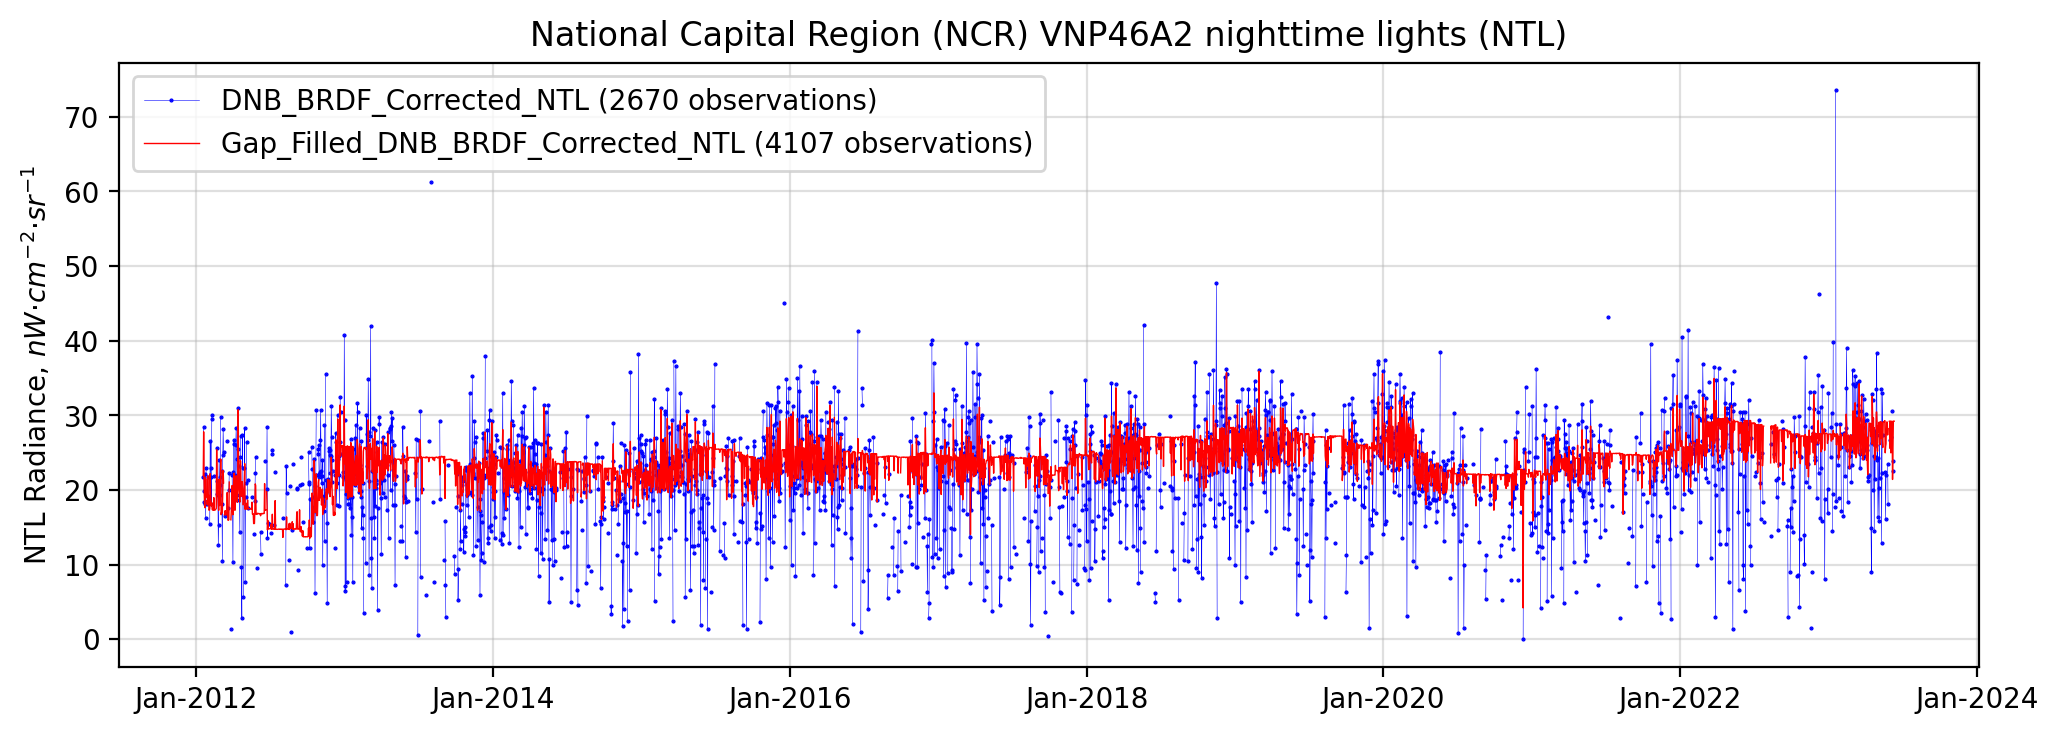

In [8]:
plt.figure(dpi = 200, figsize = (12,4))
plt.grid(alpha = 0.4)

NTL = data['DNB_BRDF_Corrected_NTL']
NTL_GF = data['Gap_Filled_DNB_BRDF_Corrected_NTL']

plt.plot(NTL, 'b.-', lw = 0.2, ms = 1,
         label = 'DNB_BRDF_Corrected_NTL (' + str(NTL.count()) + ' observations)')
plt.plot(NTL_GF, 'r-', lw = 0.5,
         label = 'Gap_Filled_DNB_BRDF_Corrected_NTL (' + str(NTL_GF.count()) + ' observations)')
plt.ylabel('NTL Radiance, $nW·cm^{−2}·sr^{−1}$')

plt.title('National Capital Region (NCR) VNP46A2 nighttime lights (NTL)')

plt.gcf().autofmt_xdate
dtFmt = mdates.DateFormatter("%b-%Y") # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.legend()
plt.show()

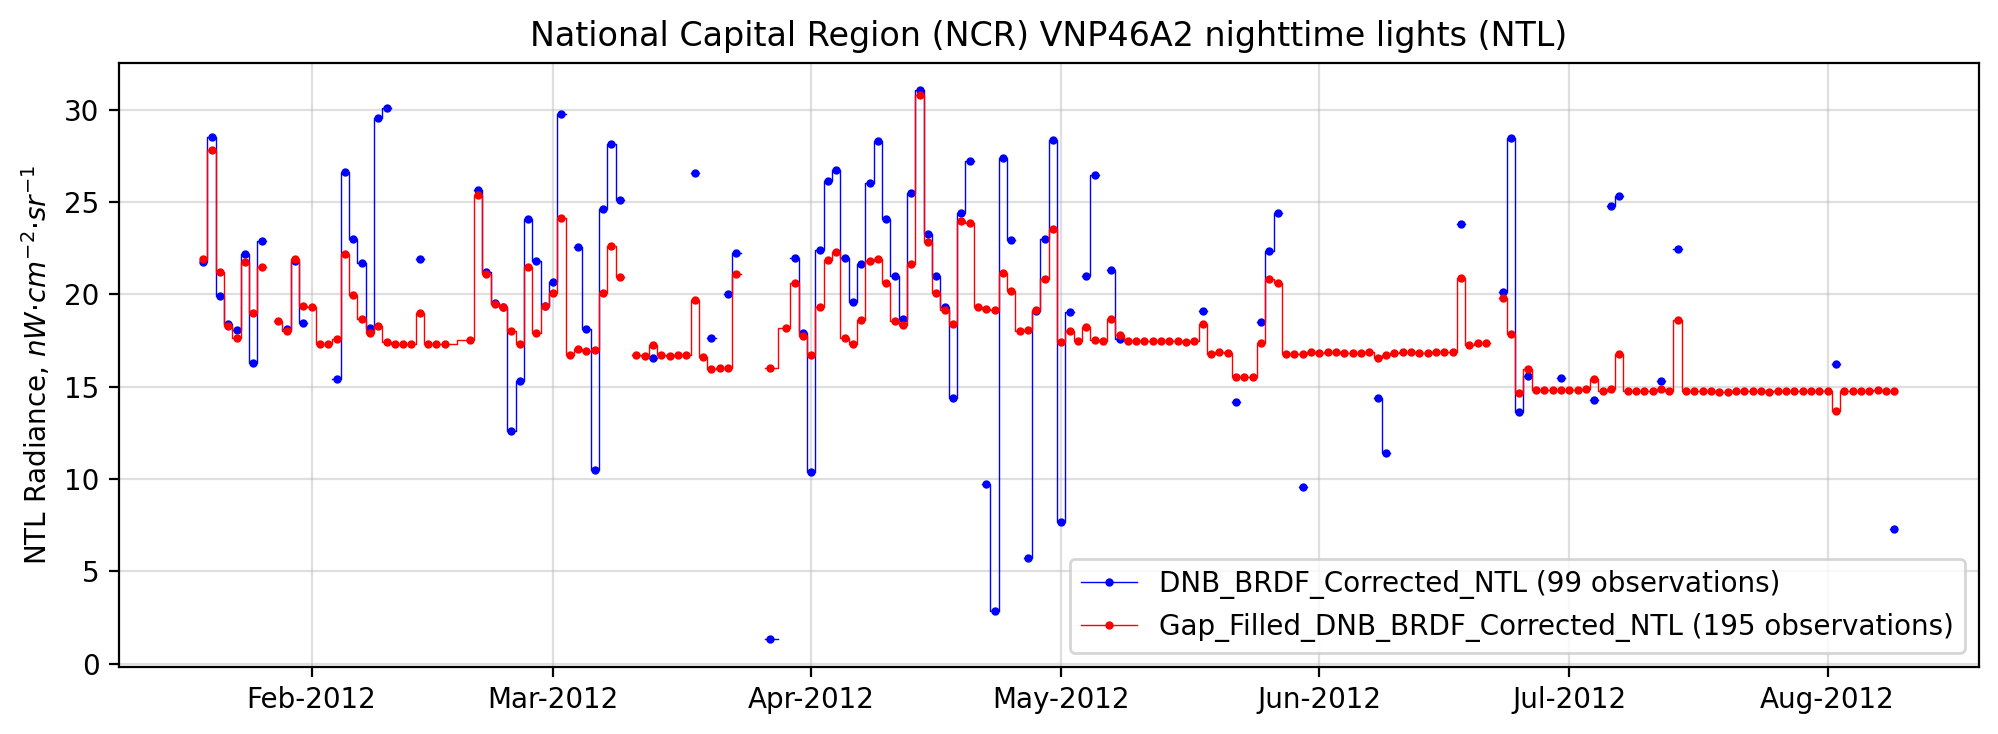

In [9]:
view = 200

plt.figure(dpi = 200, figsize = (12,4))
plt.grid(alpha = 0.4)

NTL_ = data['DNB_BRDF_Corrected_NTL'][:view]
NTL_GF_ = data['Gap_Filled_DNB_BRDF_Corrected_NTL'][:view]

plt.plot(NTL_, 'bo-', lw = 0.5, ms = 2, drawstyle = 'steps-mid',
         label = 'DNB_BRDF_Corrected_NTL (' + str(NTL_.count()) + ' observations)')
plt.plot(NTL_GF_, 'ro-', lw = 0.5,  ms = 2, drawstyle = 'steps-mid',
         label = 'Gap_Filled_DNB_BRDF_Corrected_NTL (' + str(NTL_GF_.count()) + ' observations)')
plt.ylabel('NTL Radiance, $nW·cm^{−2}·sr^{−1}$')

plt.title('National Capital Region (NCR) VNP46A2 nighttime lights (NTL)')

plt.gcf().autofmt_xdate
dtFmt = mdates.DateFormatter("%b-%Y") # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.legend()
plt.show()

### Missing datapoints

In [10]:
date_range = pd.date_range(start='2012-01-19', end='2023-06-12', freq='D')
NTL_reindexed = NTL.reindex(date_range)
NTL_GF_reindexed = NTL_GF.reindex(date_range)

NTL_missing_dates = NTL_reindexed[NTL_reindexed.isna()]
NTL_GF_missing_dates = NTL_GF_reindexed[NTL_GF_reindexed.isna()]


In [11]:
missing_days = len(date_range) - NTL_GF.count()
cloud_contaminated =  NTL.count() - missing_days

In [12]:
print("Of the " + str(len(date_range)) + " days, " + str(missing_days)+" observations are missing.")
print("Meanwhile, "+ str(cloud_contaminated) + " days are cloud contaminated, hence, gap-filled.")

Of the 4163 days, 56 observations are missing.
Meanwhile, 2614 days are cloud contaminated, hence, gap-filled.


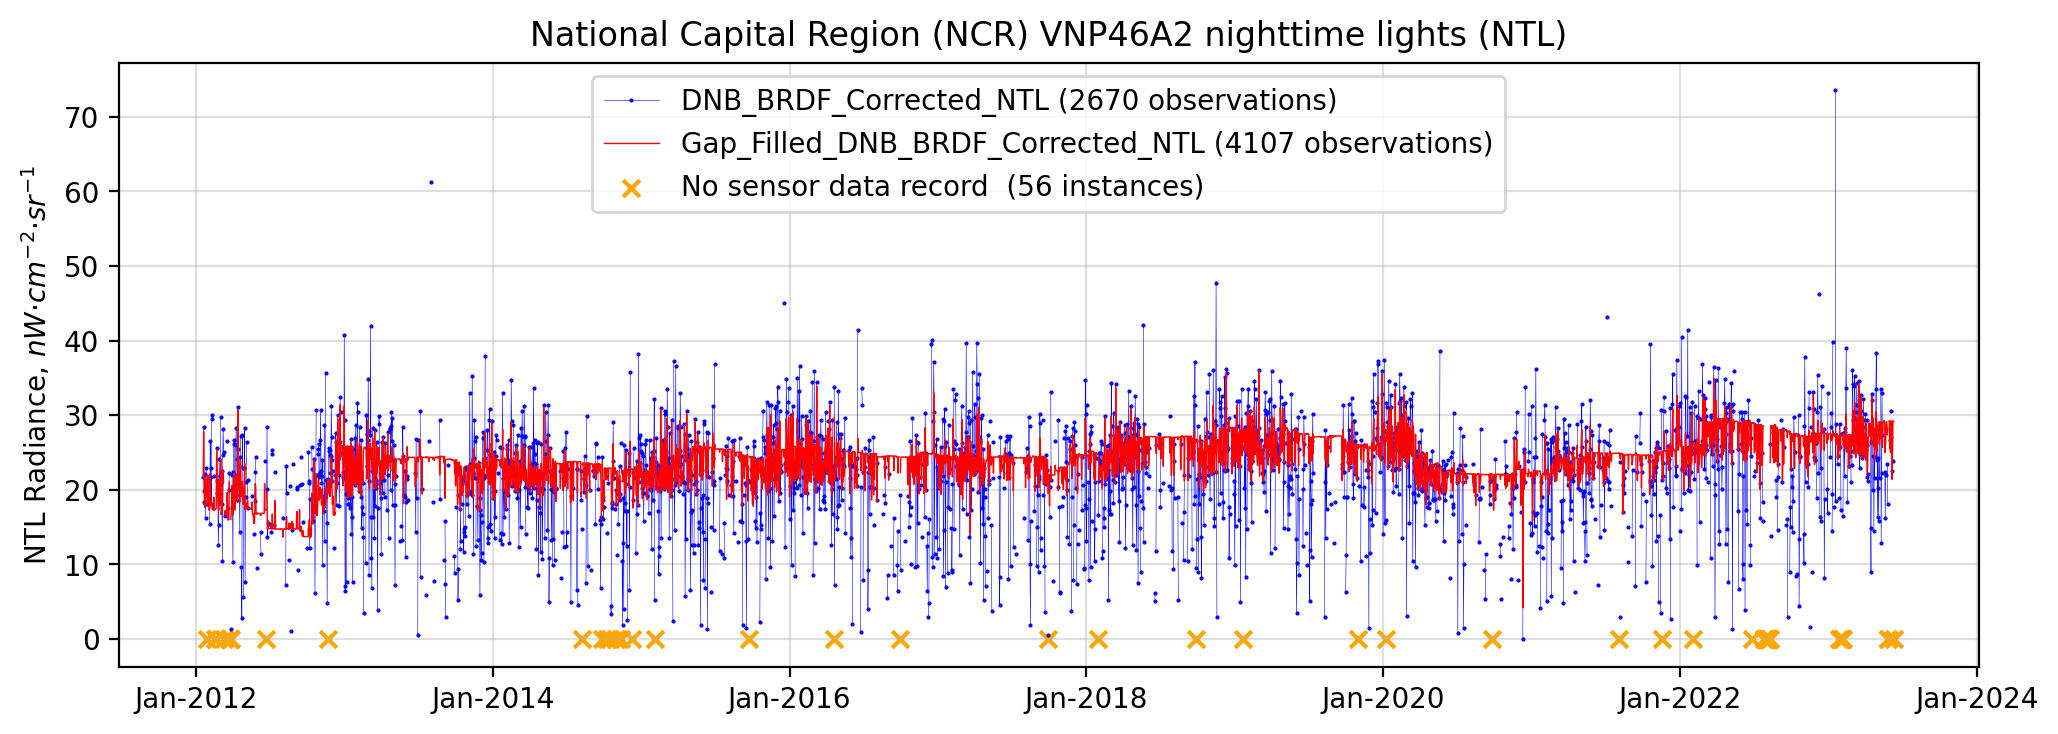

In [13]:
plt.figure(dpi = 200, figsize = (12,4))
plt.grid(alpha = 0.4)


plt.plot(NTL, 'b.-', lw = 0.2, ms = 1,
         label = 'DNB_BRDF_Corrected_NTL (' + str(NTL.count()) + ' observations)')
plt.plot(NTL_GF, 'r-', lw = 0.5,
         label = 'Gap_Filled_DNB_BRDF_Corrected_NTL (' + str(NTL_GF.count()) + ' observations)')
plt.ylabel('NTL Radiance, $nW·cm^{−2}·sr^{−1}$')

plt.title('National Capital Region (NCR) VNP46A2 nighttime lights (NTL)')

plt.gcf().autofmt_xdate
dtFmt = mdates.DateFormatter("%b-%Y") # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.scatter(NTL_GF_missing_dates.index, [0] * len(NTL_GF_missing_dates), color='orange', marker='x',
            label='No sensor data record  (' + str(missing_days) + ' instances)')
plt.legend()
plt.show()


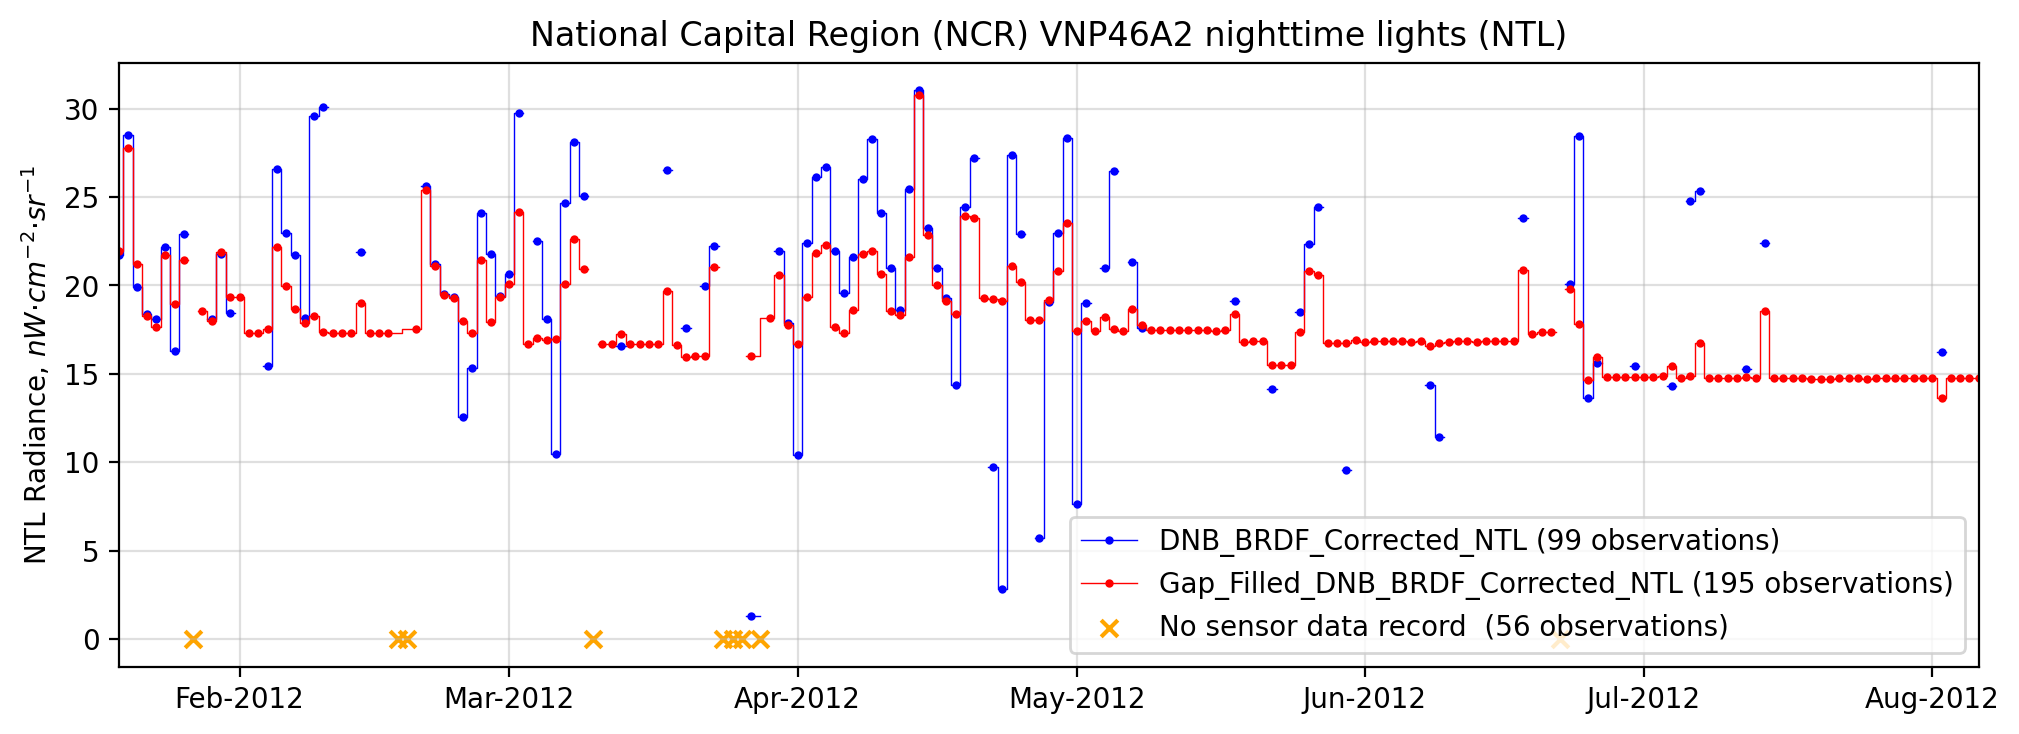

In [14]:
view = 200

plt.figure(dpi = 200, figsize = (12,4))
plt.grid(alpha = 0.4)

plt.plot(NTL_, 'bo-', lw = 0.5, ms = 2, drawstyle = 'steps-mid',
         label = 'DNB_BRDF_Corrected_NTL (' + str(NTL_.count()) + ' observations)')
plt.plot(NTL_GF_, 'ro-', lw = 0.5,  ms = 2, drawstyle = 'steps-mid',
         label = 'Gap_Filled_DNB_BRDF_Corrected_NTL (' + str(NTL_GF_.count()) + ' observations)')
plt.ylabel('NTL Radiance, $nW·cm^{−2}·sr^{−1}$')

plt.title('National Capital Region (NCR) VNP46A2 nighttime lights (NTL)')

plt.gcf().autofmt_xdate
dtFmt = mdates.DateFormatter("%b-%Y") # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis


plt.scatter(NTL_GF_missing_dates.index, [0] * len(NTL_GF_missing_dates[:view]), color='orange', marker='x',
            label='No sensor data record  (' + str(missing_days) + ' observations)')
plt.xlim(date_range[0], date_range[view])
plt.legend()
plt.show()

## Generating PDFs

In [15]:
data_sample = NTL_GF
n = len(data_sample)

We select τ = 7 (weekly scale)

In [16]:
tau = 7 #7 days
dt = 1 #1 day interval

delta = int(np.round(tau/dt))
print("tau: %d, Delta: %d" % (tau, delta))

tau: 7, Delta: 7


In [17]:
data_trunc = data_sample[:-1*delta]
data_shift = data_sample[delta:]
dx = data_shift.values - data_trunc.values
len(dx), len(data_trunc), len(data_shift)

(4135, 4135, 4135)

In [18]:
data_trunc.head(), data_shift.head()

(date
 2012-01-19    21.923586
 2012-01-20    27.802954
 2012-01-21    21.199934
 2012-01-22    18.264756
 2012-01-23    17.632629
 Name: Gap_Filled_DNB_BRDF_Corrected_NTL, dtype: float64,
 date
 2012-01-26    21.449830
 2012-01-27          NaN
 2012-01-28    18.568147
 2012-01-29    17.997314
 2012-01-30    21.906167
 Name: Gap_Filled_DNB_BRDF_Corrected_NTL, dtype: float64)

In [19]:
# view = 200
# plt.figure(dpi = 150, figsize = (15,3))
# plt.grid()
# plt.plot(data_trunc[:view].values, 'b.-', alpha = 0.5, label = 'truncated NTL')
# plt.plot(data_shift[:view].values, 'g.-', alpha = 0.5, label = 'shifted NTL')
# plt.plot(dx[:view-tau], drawstyle = 'steps-mid', color = 'red', label = 'displacements')
# plt.legend()
# plt.show()

# plt.figure(dpi = 150, figsize = (15,3))
# plt.grid()
# plt.plot(data_trunc.values, 'b.-', alpha = 0.5, ms = 1, lw = 0.5, label = 'truncated NTL')
# plt.plot(data_shift.values, 'g.-', alpha = 0.5, ms = 1, lw = 0.5, label = 'shifted NTL')
# plt.plot(dx[:-tau], drawstyle = 'steps-mid', lw = 0.5, color = 'red', label = 'displacements')
# plt.legend()
# plt.show()

In [20]:
# # Generate normal distribution
# xx_sd = np.sqrt(tau)
# xx = np.linspace(-5, 5)*xx_sd # gridded points from -5 to 5 in units of sd
# xx_mean = 0.
# yy = norm.pdf(xx, xx_mean, xx_sd)

# plt.figure(figsize=(8,3), dpi = 150)
# plt.grid(alpha = 0.4)
# # Plot PDF of displacements
# plt.hist(dx, density=True, bins="auto", label="NTL displacements histogram", color = 'red')
# plt.xlabel("Delta x")
# plt.ylabel("PDF")

# # # Overlay normal distribution
# plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
# plt.ylabel("PDF")
# plt.xlabel(r"$\Delta x$")
# plt.legend(loc="best")

# plt.minorticks_on()
# plt.xlabel(r"$\Delta x$")
# plt.ylabel("PDF")
# plt.title(r"Lag time: $\Delta=$%d days" % (tau))

In [21]:
NTL_dx = get_sample_dx(data_sample.values, delta)

xlimit = 20.
n_bins = 50
bin_edges = np.linspace(xlimit*-1., xlimit, n_bins+1)
pdf = get_pdf(NTL_dx, tau, bin_edges, norm=False)
              
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
sigma2, err_sigma2, N, err_N = fit_pdf(bin_centers, pdf)
xx = np.linspace(xlimit*-1., xlimit)
yy = gaussian(xx, sigma2, N)

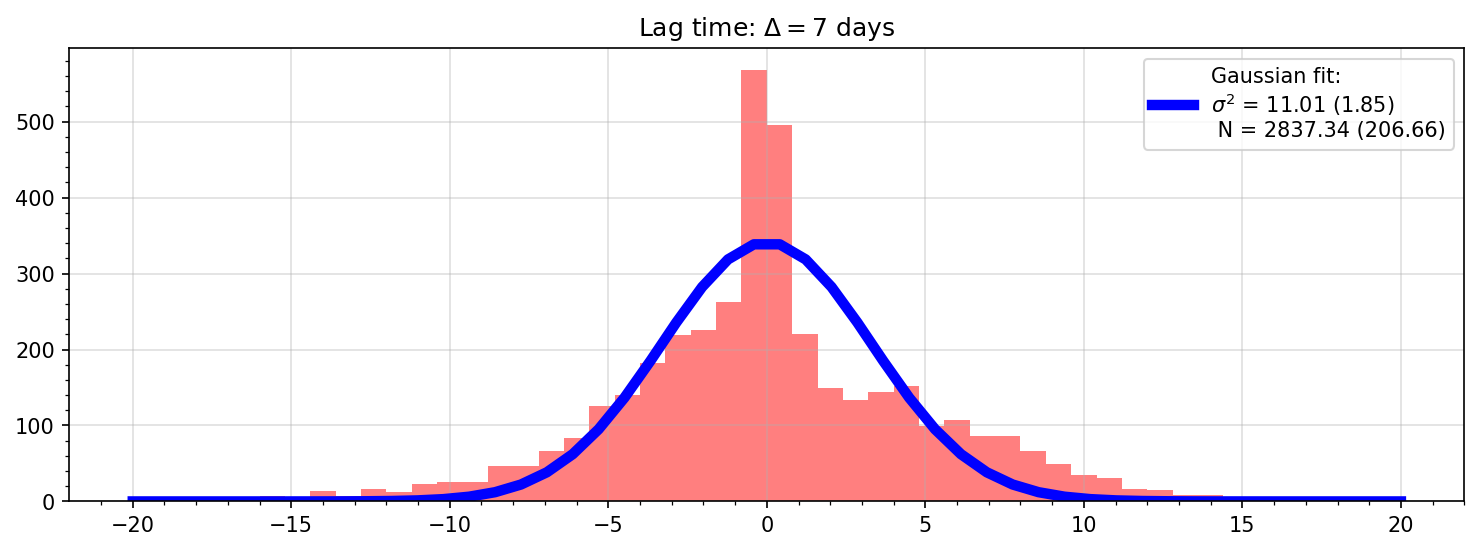

In [22]:
plt.figure(dpi = 150, figsize = (12,4))
plt.grid(alpha = 0.4)
plt.stairs(pdf, bin_edges, fill=True, alpha = 0.5, color = 'red')
plt.plot(xx,yy, 'b-', lw = 5, label = "Gaussian fit: \n" \
        + r"$\sigma^2$ = %.2f (%.2f)" % (sigma2, err_sigma2) \
         + "\n N = %.2f (%.2f)" % (N, err_N))
plt.minorticks_on()
plt.title(r"Lag time: $\Delta=$%d days" % (tau))
plt.legend()
plt.show()

### Relevant Lag times (1,   4,   7,  14,  21,  30,  90, 365)

In [23]:
tau_vals_1 = np.array([1, 4, 7, 14, 21, 30, 90, 365])

In [24]:
def plot_PDF(data_sample, tau, xlimit, n_bins, y_max, c):
    NTL_dx = get_sample_dx(data_sample.values, tau)
    bin_edges = np.linspace(xlimit*-1., xlimit, n_bins+1)
    pdf = get_pdf(NTL_dx, tau, bin_edges, norm=True)

    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    sigma2, err_sigma2, N, err_N = fit_pdf(bin_centers, pdf)
    xx = np.linspace(xlimit*-1., xlimit)
    yy = gaussian(xx, sigma2, N)

    plt.grid(alpha = 0.4)
    plt.stairs(pdf, bin_edges, fill=True, alpha = 0.5, color = c)
    plt.plot(xx,yy, 'k-', lw = 3, label = "Gaussian fit: \n" \
            + r"$\sigma^2$ = %.2f (%.2f)" % (sigma2, err_sigma2) \
             + "\n N = %.2f (%.2f)" % (N, err_N))
    plt.minorticks_on()
    plt.title(r"Lag time: $\tau=$%d days" % (tau))
    plt.legend(loc = 0)
    plt.ylim(0, y_max)

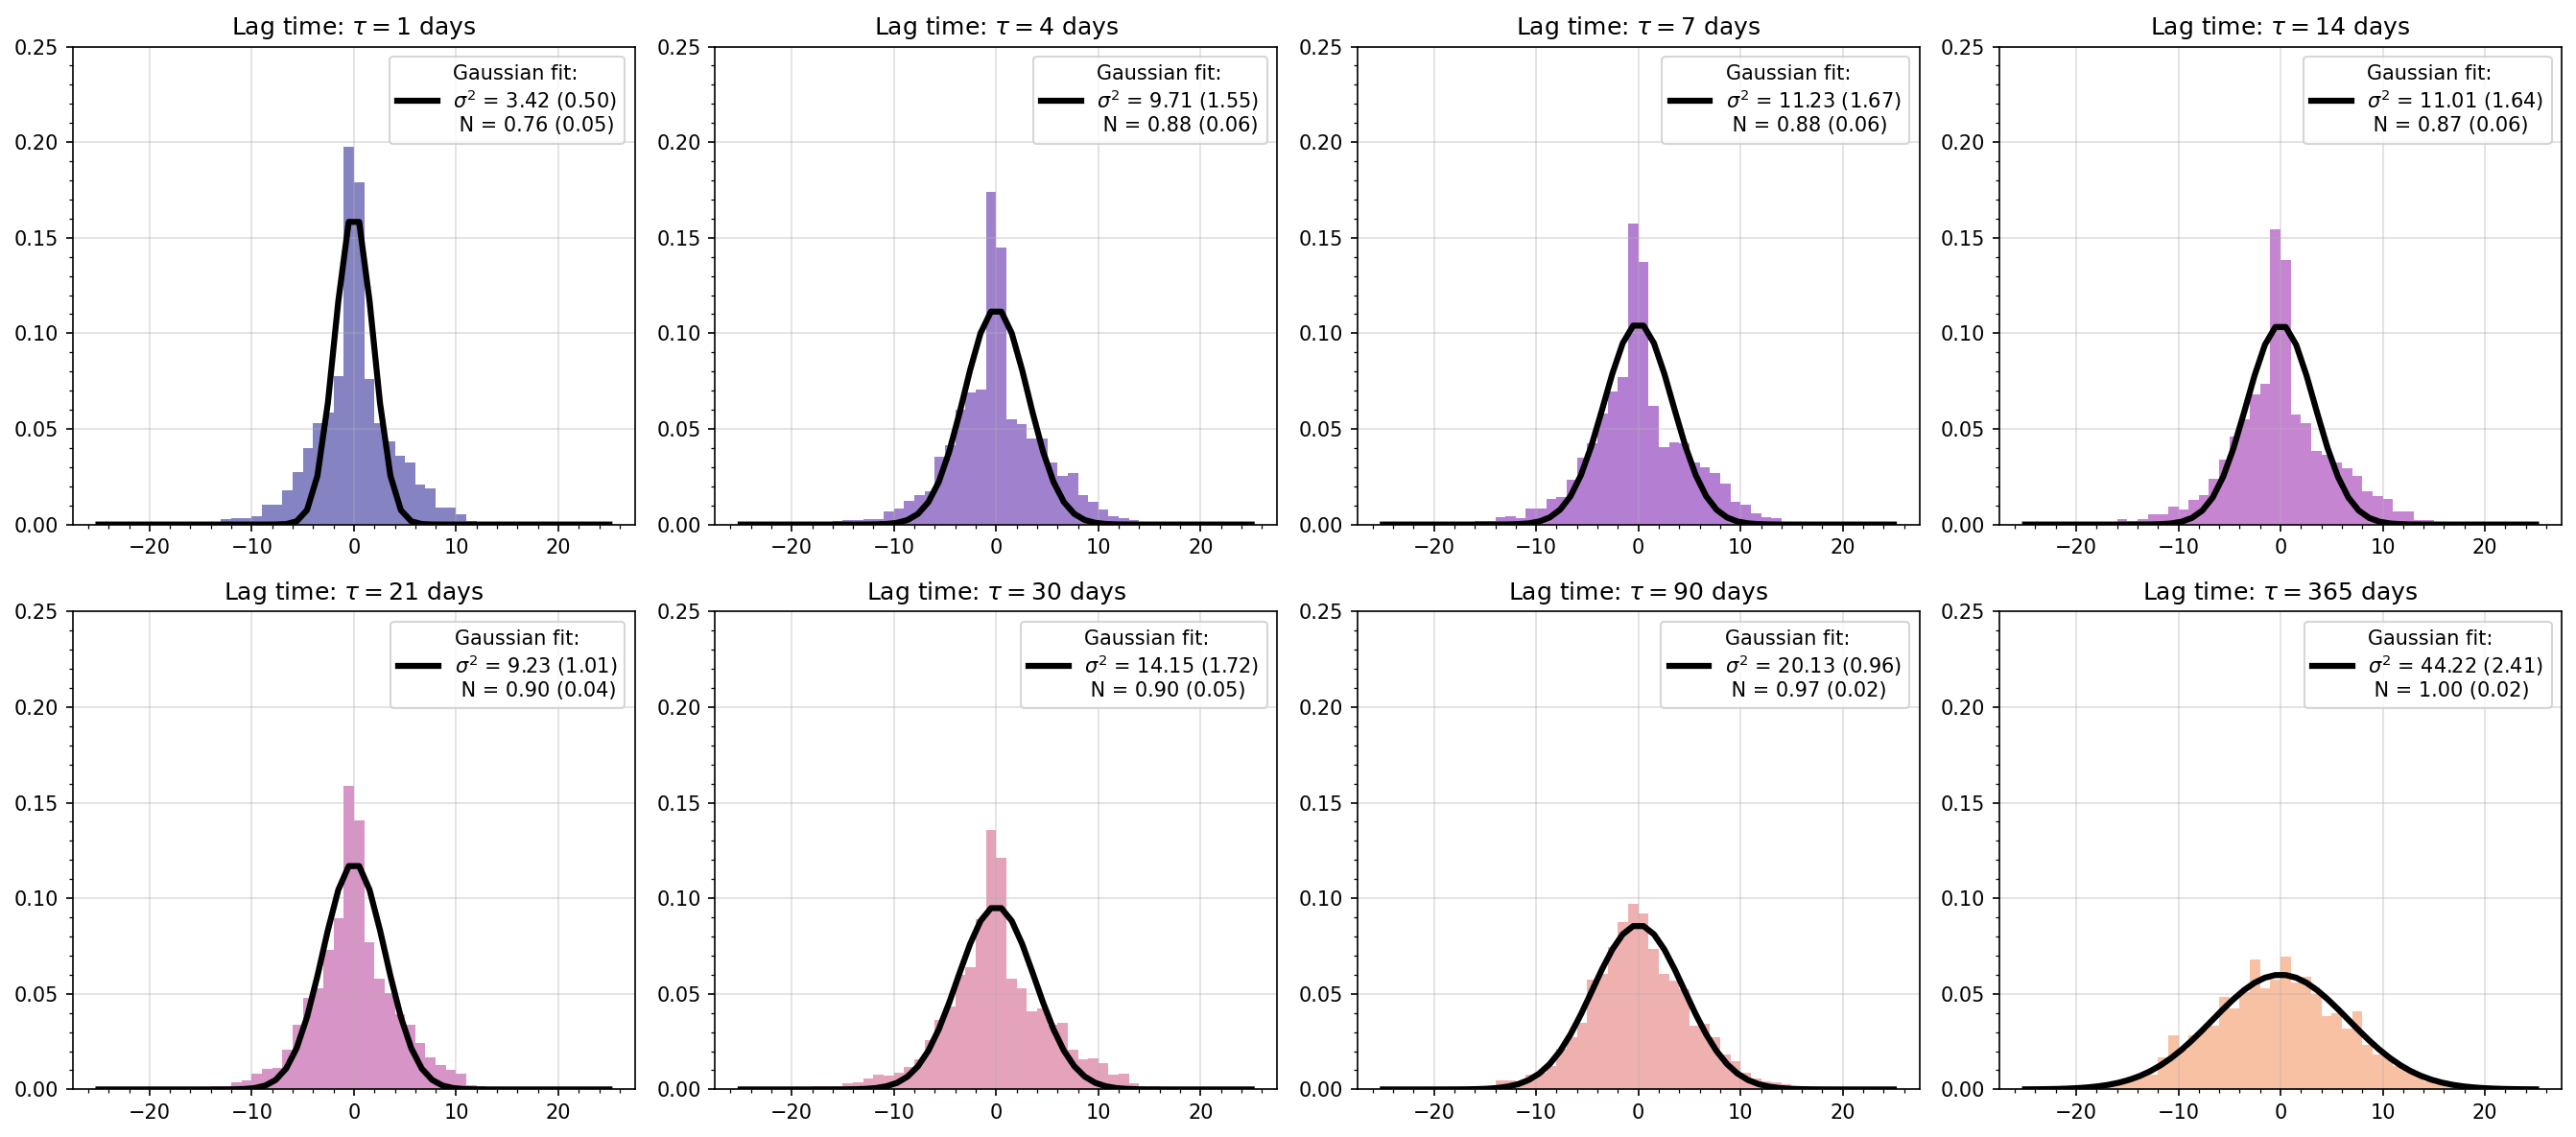

In [25]:
tau_vals_1 = np.array([1, 4, 7, 14, 21, 30, 90, 365])

plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF(data_sample, tau, xlimit = 25, n_bins = 50, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

### Log-spaced time intervals (1,    3,   10,   31,  100,  316, 1000, 3162)

In [26]:
n_delta_init = 8 # later, can increase this
logdelta_min = 0
logdelta_max = 3.5
delta_vals = np.unique(np.floor(np.logspace(logdelta_min, logdelta_max, n_delta_init))).astype(int)
delta_vals

array([   1,    3,   10,   31,  100,  316, 1000, 3162])

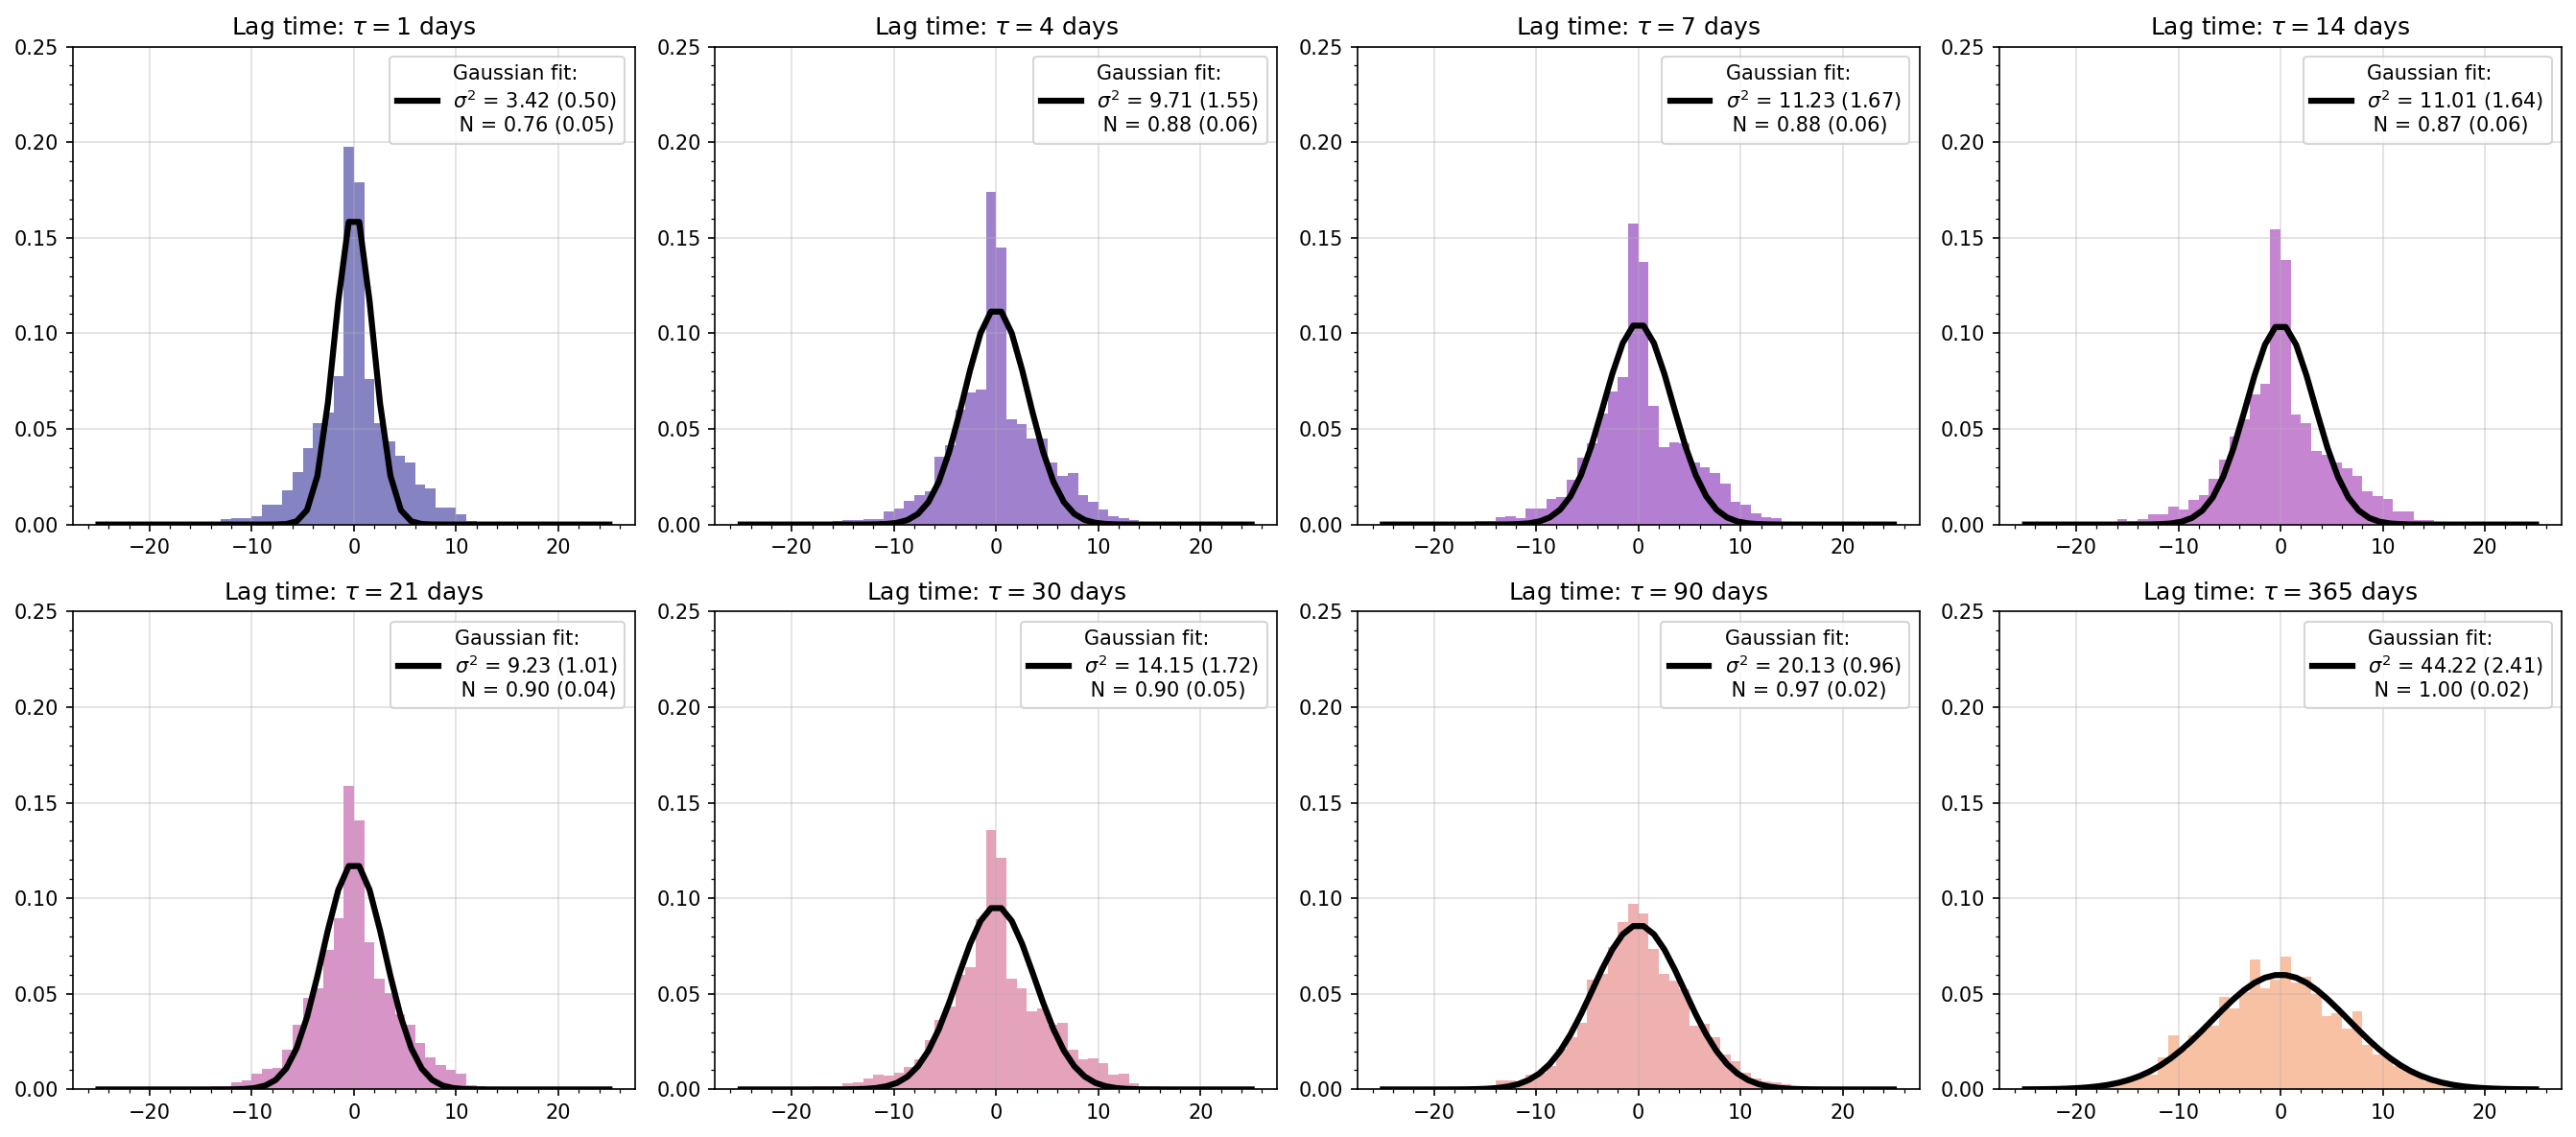

In [27]:
plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF(data_sample, tau, xlimit = 25, n_bins = 50, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## Generating MSDs

### Discrete Lag Times

In [28]:
n_delta_init = 30 # later, can increase this
logdelta_min = 0
logdelta_max = 3.5
delta_vals = np.unique(np.floor(np.logspace(logdelta_min, logdelta_max, n_delta_init))).astype(int)
delta_vals

n = len(data)
n_samp = 1
n_tau = len(delta_vals)
dx_tau = np.empty((n, n_tau))*np.nan
for i, tau in tqdm(enumerate(delta_vals)):
    delta = delta_vals[i]
    data_trunc = data_sample[:-1*delta]
    data_shift = data_sample[delta:]
    dx = data_shift.values - data_trunc.values
    dx_tau[:len(dx), i] = dx.T

28it [00:00, 6257.15it/s]


In [29]:
msd_tau = np.empty((n_tau, n_samp))*np.nan
for i, tau in enumerate(delta_vals):
    dx2_sum = np.nansum(dx_tau[:, i]**2) # returns sum treating NaNs as zero
    denom = n-delta_vals[i]
    msd_tau[i] = dx2_sum/denom

In [30]:
def show_markers():
    for year in np.arange(1,11)*7: plt.axvline(year, ls=':', color = 'g', lw = 2, alpha = 0.5)
    plt.axvline(7, ls='-', color = 'g', lw = 2, label = 'multiples of 1 week')
    for year in np.arange(1,11)*365: plt.axvline(year, ls=':', color = 'b', lw = 2, alpha = 0.5)
    plt.axvline(365, ls='-', color = 'b', lw = 2, label = 'multiples of 1 year')

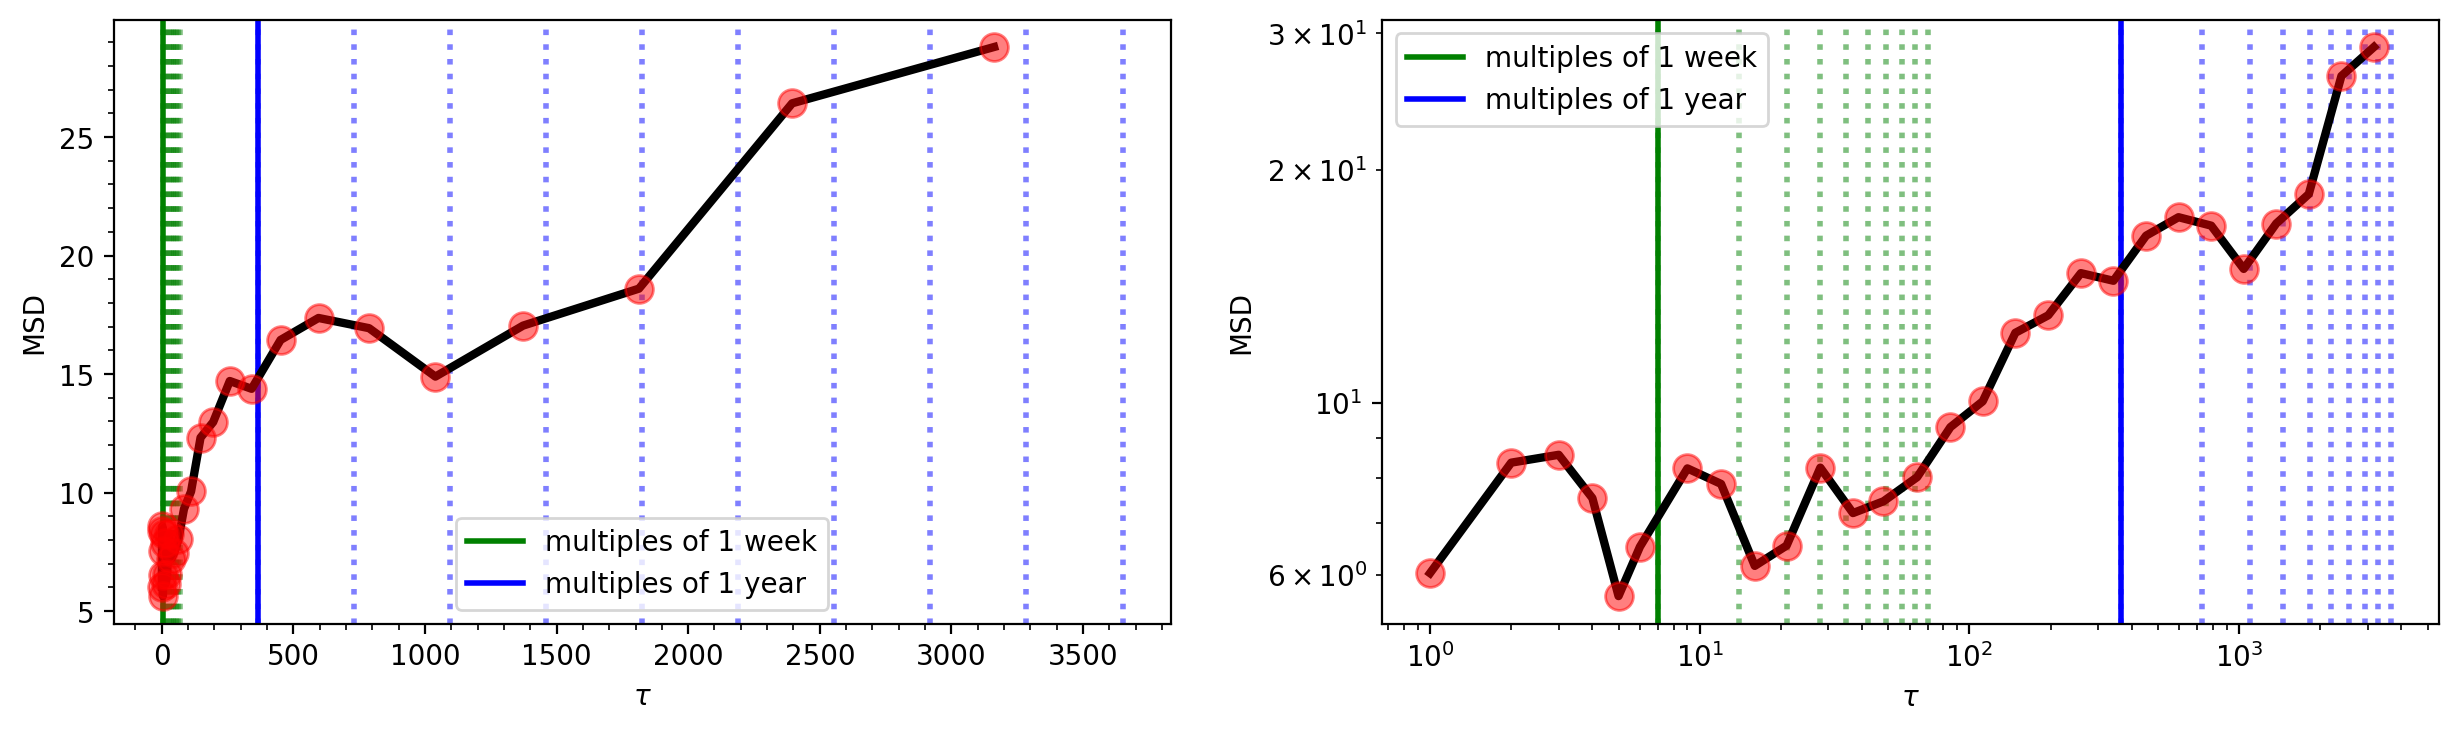

In [31]:
plt.figure(dpi = 200, figsize = (15,4))
plt.subplot(121)
show_markers()
plt.plot(delta_vals, msd_tau, 'k-', lw = 3)
plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 10)
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")
plt.legend()
plt.minorticks_on()


plt.subplot(122)
show_markers()
plt.plot(delta_vals, msd_tau, 'k-', lw = 3)
plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 10)
msd_theo = delta_vals
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")
plt.legend()
plt.minorticks_on()

plt.show()

Here we can see a particular periodicity in the MSD plots, however, take note that we are using a discretize set of delta values that are log-spaced. NTL is an output of a complex system of nocturnal lighting from artificial and natural sources hence, I reckon that each timescale (and thus lag-time) must be investigated by plotting its corresponding MSD.

### Continuous Lag Times

4142it [00:00, 16660.36it/s]


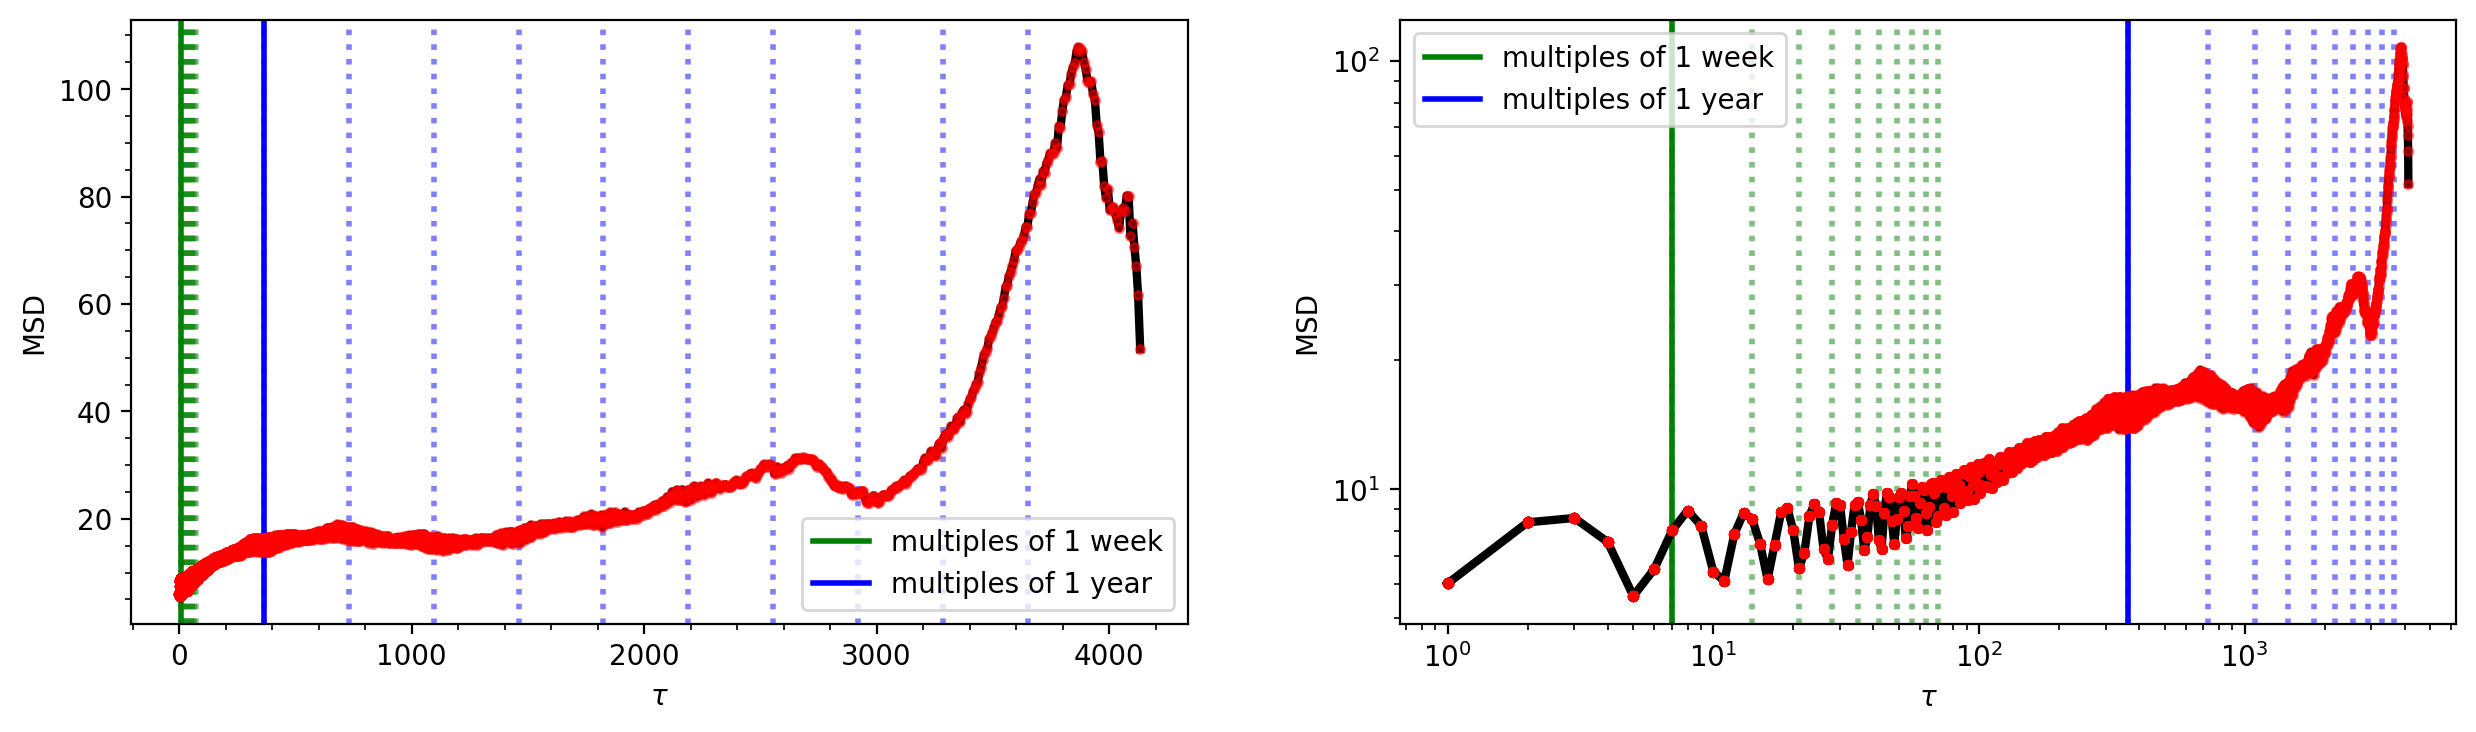

In [32]:
n_tau = len(data_sample)
tau_vals = np.logspace(0,np.log10(n_tau), n_tau)
delta_vals = np.round(tau_vals/dt).astype(int)

n = len(data)
n_samp = 1
n_tau = len(tau_vals)
dx_tau = np.empty((n, n_tau))*np.nan
for i, tau in tqdm(enumerate(tau_vals)):
    delta = delta_vals[i]
    data_trunc = data_sample[:-1*delta]
    data_shift = data_sample[delta:]
    dx = data_shift.values - data_trunc.values
    dx_tau[:len(dx), i] = dx.T
    
msd_tau = np.empty((n_tau, n_samp))*np.nan
for i, tau in enumerate(tau_vals):
    dx2_sum = np.nansum(dx_tau[:, i]**2) # returns sum treating NaNs as zero
    denom = n-delta_vals[i]
    msd_tau[i] = dx2_sum/denom

plt.figure(dpi = 200, figsize = (15,4))
plt.subplot(121)
show_markers()
plt.plot(delta_vals, msd_tau, 'k-', lw = 3)
plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")
plt.legend()
plt.minorticks_on()


plt.subplot(122)
show_markers()
plt.plot(delta_vals, msd_tau, 'k-', lw = 3)
plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
msd_theo = tau_vals
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")
plt.legend()
plt.minorticks_on()

plt.show()

Markers indicating multiples of the week and year are displayed as the magenta and cyan lines, respectively. Noticeably, a linear and exponential regime in the MSD is evident in the weekly and yearly timescales.

### Automating the plots

In [33]:
def MSD_plotted(data):
    plt.figure(dpi = 150, figsize = (15,3))
    plt.grid()
    plt.plot(data, 'g.-', drawstyle = 'steps-mid', alpha = 0.5, ms = 1, lw = 1)
    plt.text(datetime.date(2012, 1, 19), data.mean(), str(data.describe()),
             fontsize=7, bbox=dict(facecolor='white', alpha=0.8))
    plt.ylabel('NTL Radiance, $nW·cm^{−2}·sr^{−1}$')

    n_tau = len(data)
    tau_vals = np.logspace(0,np.log10(n_tau), n_tau)
    delta_vals = np.round(tau_vals/dt).astype(int)

    n = len(data)
    n_samp = 1
    n_tau = len(tau_vals)
    dx_tau = np.empty((n, n_tau))*np.nan

    for i, tau in tqdm(enumerate(tau_vals)):
        delta = delta_vals[i]
        data_trunc = data[:-1*delta]
        data_shift = data[delta:]
        dx = data_shift.values - data_trunc.values
        dx_tau[:len(dx), i] = dx.T

    msd_tau = np.empty((n_tau, n_samp))*np.nan
    for i, tau in enumerate(tau_vals):
        dx2_sum = np.nansum(dx_tau[:, i]**2)
        denom = n-delta_vals[i]
        msd_tau[i] = dx2_sum/denom

    plt.figure(dpi = 150, figsize = (15,3))

    plt.subplot(121)
    show_markers()
    plt.plot(delta_vals, msd_tau, 'k-', lw = 1)
    plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    plt.legend()
    plt.minorticks_on()


    plt.subplot(122)
    show_markers()
    plt.plot(delta_vals, msd_tau, 'k-', lw = 1)
    plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
    msd_theo = tau_vals
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    plt.legend()
    plt.minorticks_on()

    plt.show()

### [MSD] NTL data

4142it [00:00, 16884.41it/s]


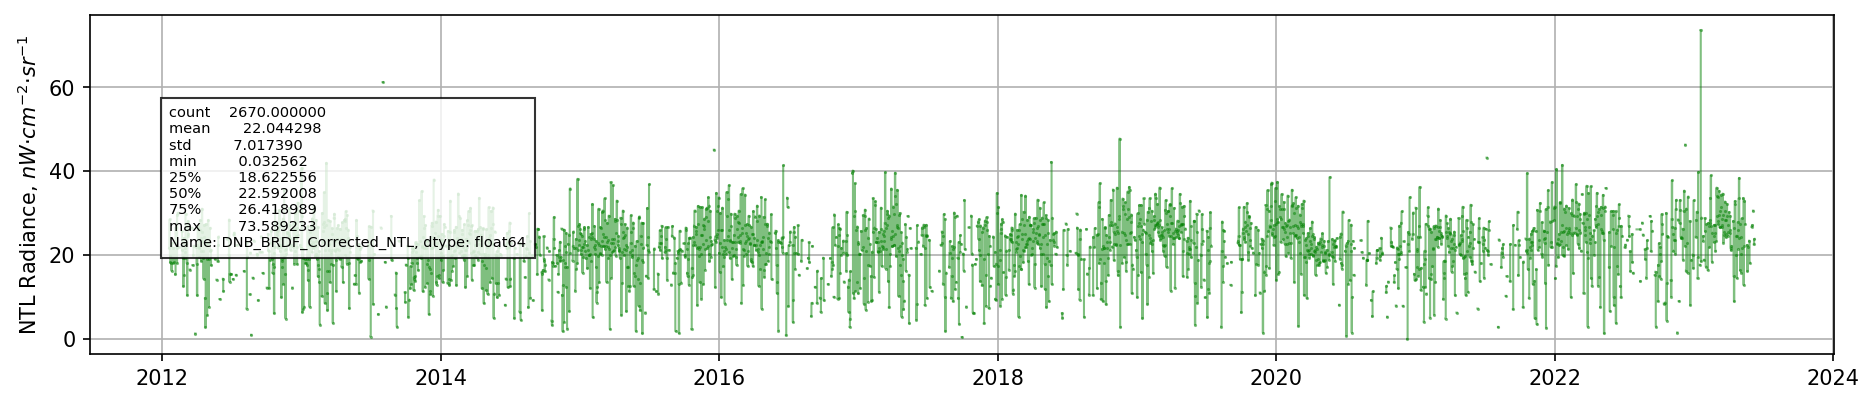

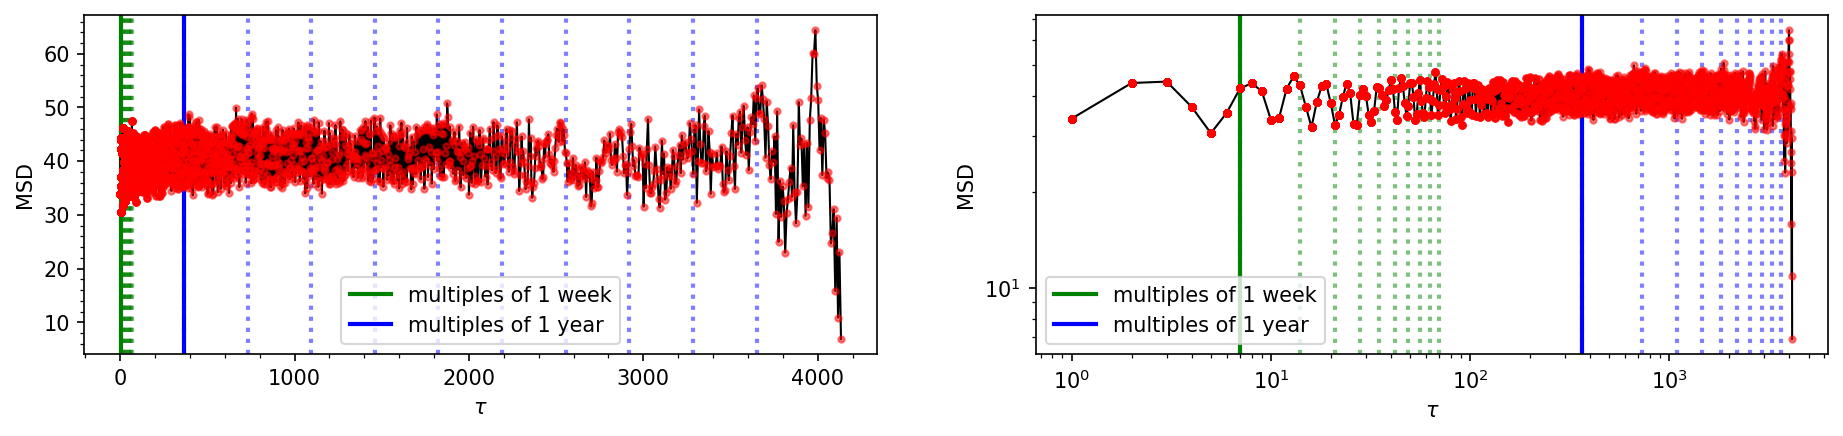

In [34]:
MSD_plotted(data['DNB_BRDF_Corrected_NTL'])

Using the untreated raw data renders a seemingly subdiffusive MSD plot, however, it's reliability is still in question especially that roughly half of the data is missing due to cloud cover. 

### [MSD] Gap Filled NTL data

4142it [00:00, 16612.19it/s]


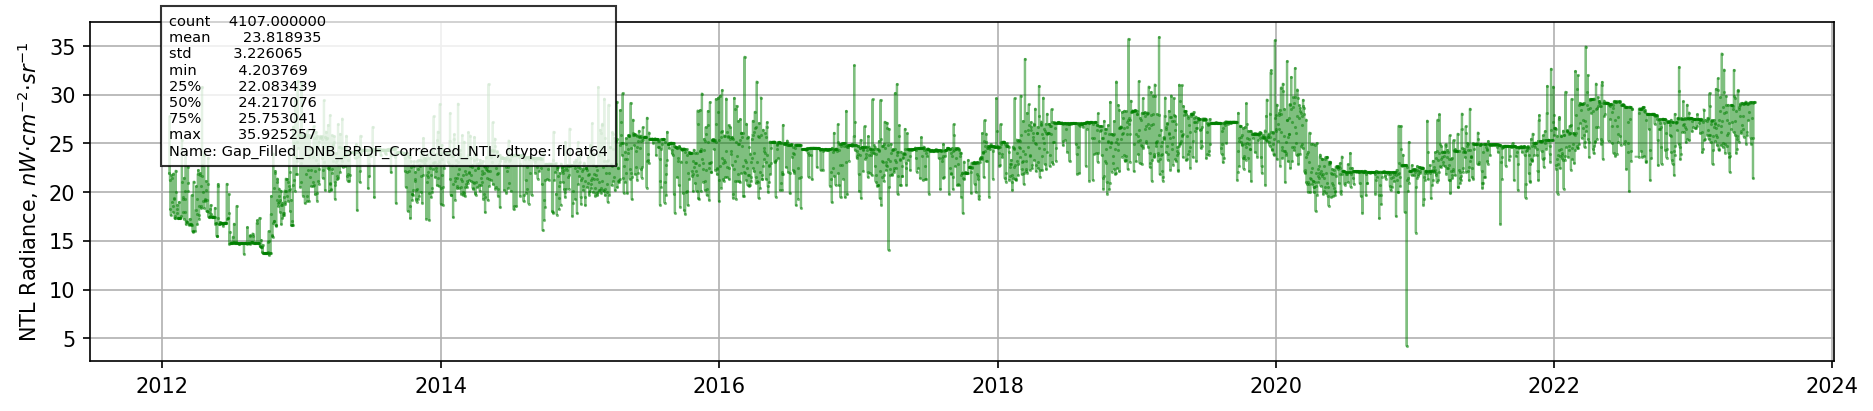

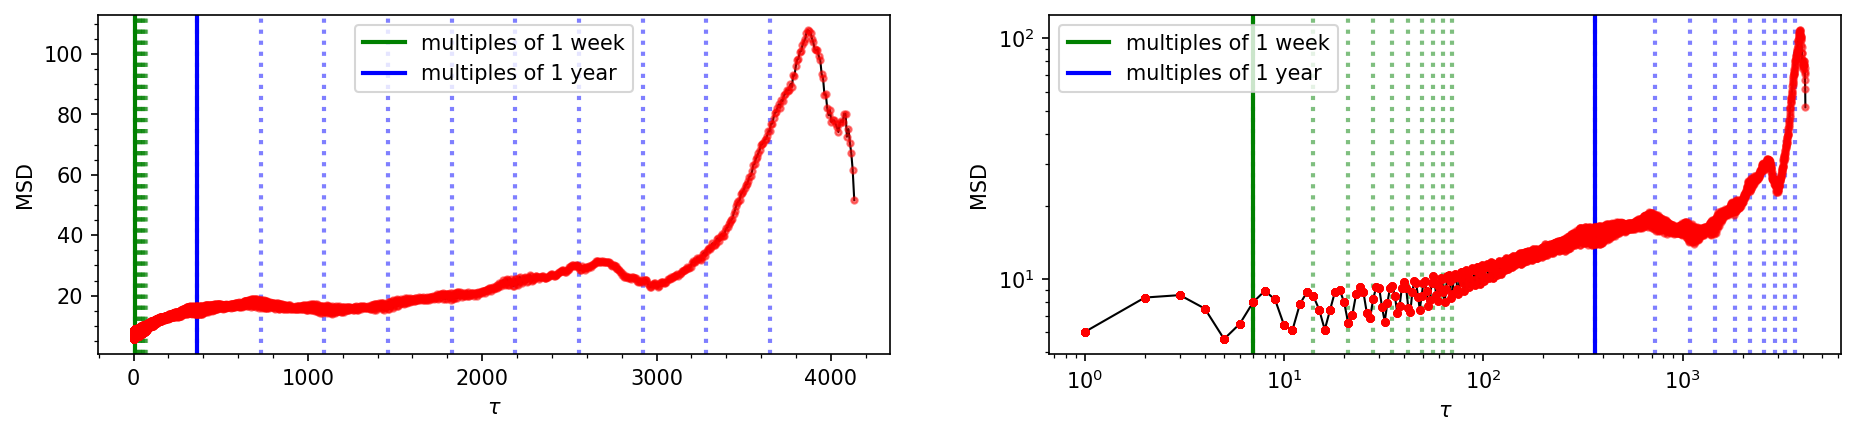

In [35]:
MSD_plotted(NTL_GF)

With Gap Filling algorithm on Black Marble, the data is now more continious and corrected for all the other effects. We can see here a periodic fluctuation in MSD but overall an increasing trend through larger lag times. NTL has been established to represent long term economic progression hence, this increase in trend is captures by setting larger values of $\tau$.

### [MSD] Lunar Irradiance data

4142it [00:00, 17328.95it/s]


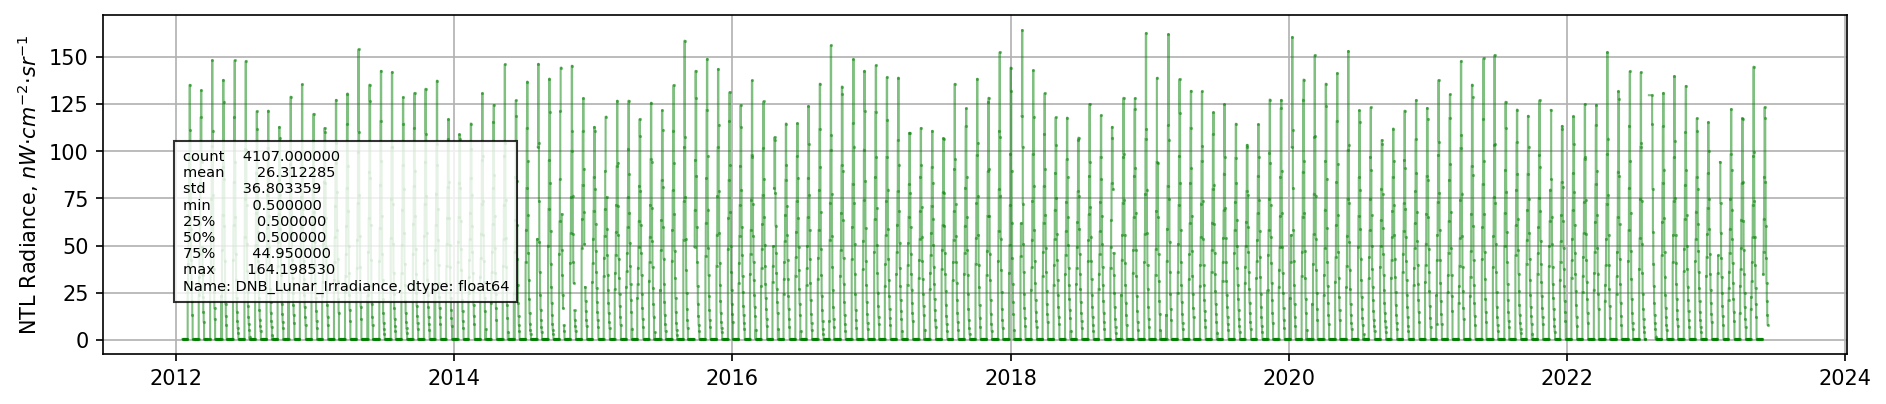

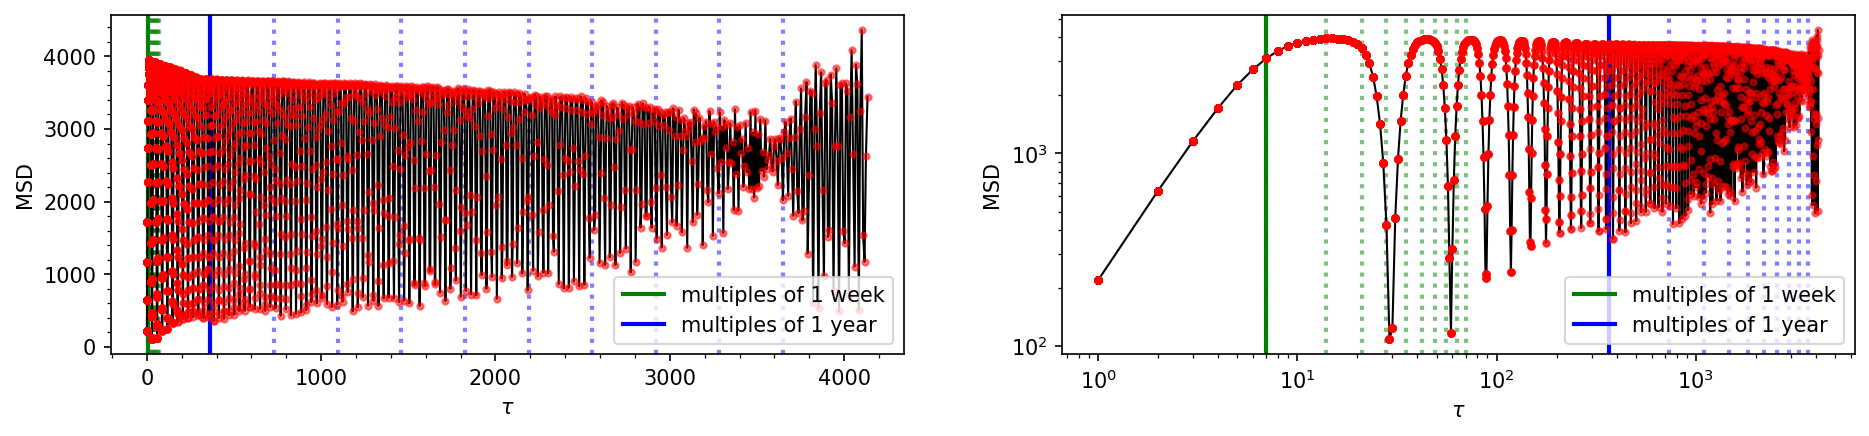

In [36]:
MSD_plotted(data['DNB_Lunar_Irradiance'])

A layer of VNP46A2 accounts for the lunar effects that is used for correction and here we can see that the MSD periodically drops on multiples of 4 weeks, which is representative of one lunar cycle. 

### [MSD] Latest High Quality Retrieval data (in unit of days)

4142it [00:00, 17019.85it/s]


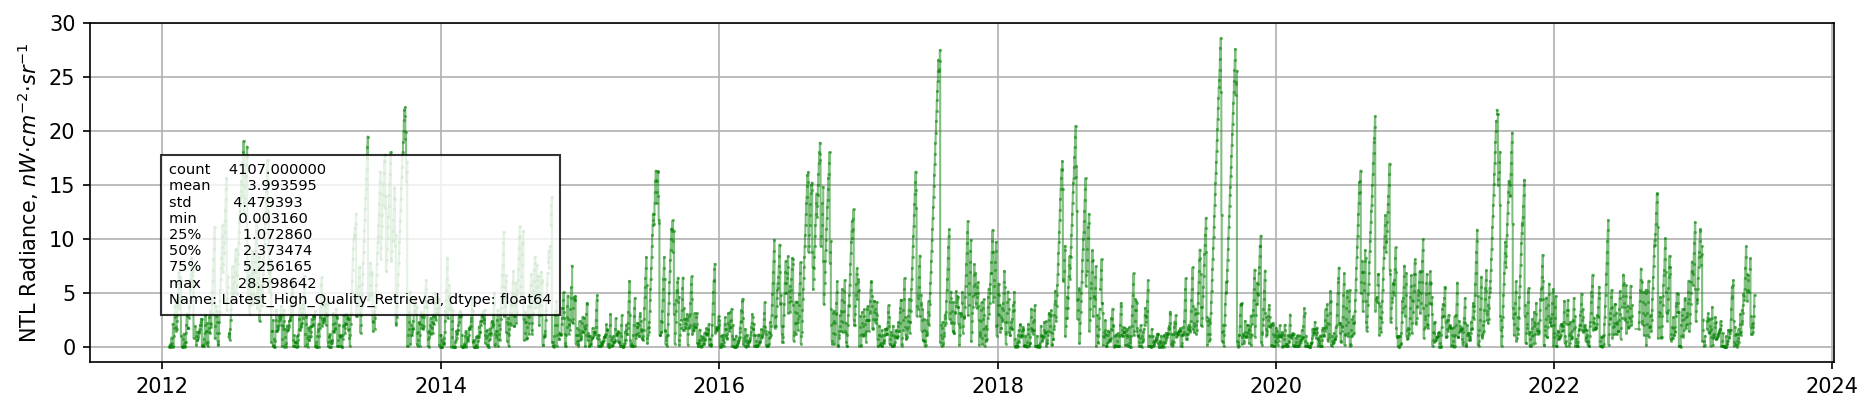

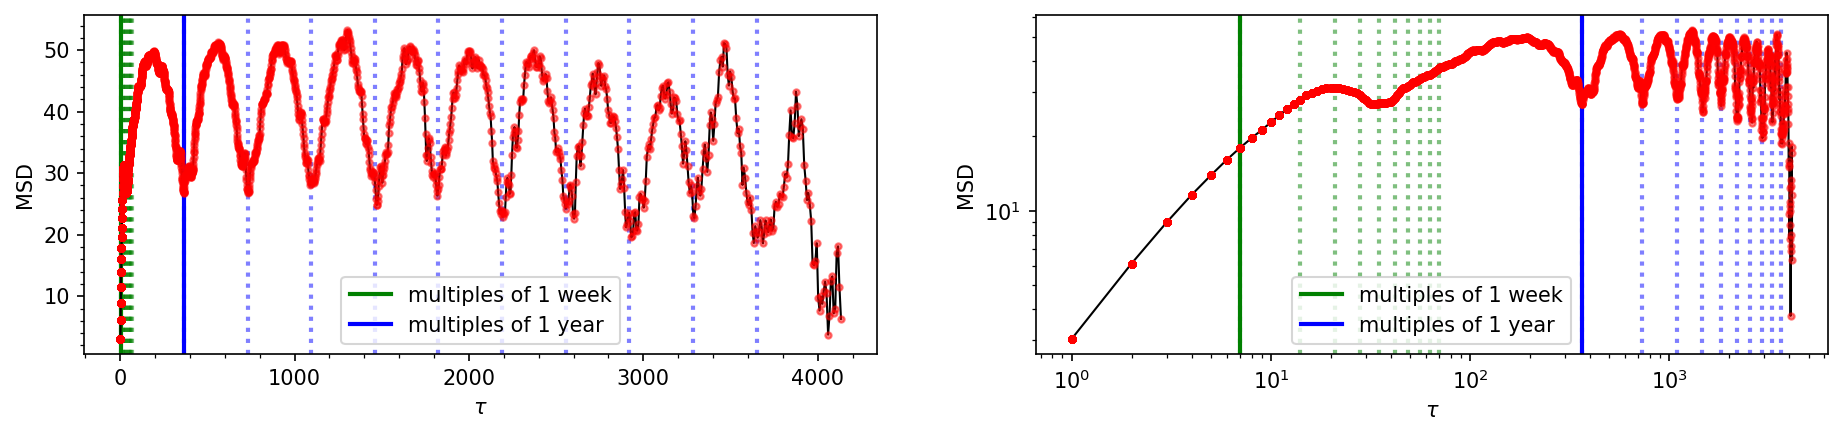

In [37]:
MSD_plotted(data['Latest_High_Quality_Retrieval'])

## MSD for Regional Gap Filled NTL data

In this portion, the MSD for the NTL values aggregated on a regional scale is shown and characteristic behaviors were observed. However, a further data processing is needed to clean some of the datasets with extreme outliers which eventually affected the MSD plots.

In [43]:
import os

data_path = "../Project/data/VNP46A2_regional/"
regional_NTL = os.listdir(data_path)
regional_NTL
# "../data//

['Region XII_NTL_VNP46A2.csv',
 'Region VI_NTL_VNP46A2.csv',
 'Region II_NTL_VNP46A2.csv',
 '.DS_Store',
 'ARMM_NTL_VNP46A2.csv',
 'Region IV-A_NTL_VNP46A2.csv',
 'Region I_NTL_VNP46A2.csv',
 'Region XI_NTL_VNP46A2.csv',
 'Region IX_NTL_VNP46A2.csv',
 'Region III_NTL_VNP46A2.csv',
 'NCR_NTL_VNP46A2.csv',
 'Region XIII_NTL_VNP46A2.csv',
 'Region VII_NTL_VNP46A2.csv',
 'Region VIII_NTL_VNP46A2.csv',
 'Region X_NTL_VNP46A2.csv',
 'CAR_NTL_VNP46A2.csv']

In [39]:
# dataframe = pd.read_csv(data_path+NTL_data, parse_dates=True, index_col = 0)
# data = dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL']
# # dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'].quantile(0.99)

# dataframe = dataframe[(dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'] < q_hi) & (dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'] > q_low)]

In [40]:
def outlier_removal(dataframe):
    q_low = dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'].quantile(0.01)
    q_hi  = dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'].quantile(0.99)
    dataframe = dataframe[(dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'] < q_hi) & (dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL'] > q_low)]
    return dataframe

In [41]:
regions = []
BM_NTL = []
MSD_reg_NTL = []

for NTL_data in tqdm(regional_NTL):
    
    regions.append(str(NTL_data[:-16]))

    dataframe = pd.read_csv(data_path+NTL_data, parse_dates=True, index_col = 0) 
                            #encoding='unicode_escape', error_bad_lines=False)    
    dataframe = outlier_removal(dataframe)
    data = dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL']
    
    BM_NTL.append(data)
    
    date_range = pd.date_range(start='2012-01-19', end='2023-06-12', freq='D')
    data_reindexed = data.reindex(date_range)
    NTL_missing_dates = data_reindexed[data_reindexed.isna()]
    no_obs = len(NTL_missing_dates)

#     plt.figure(dpi = 150, figsize = (15,3))
#     plt.grid()
#     plt.plot(data, 'g.-', drawstyle = 'steps-mid', alpha = 0.5, ms = 1, lw = 1)
#     plt.text(datetime.date(2012, 1, 19), data.mean()*2, str(data.describe()),
#              fontsize=7, bbox=dict(facecolor='white', alpha=0.8))
#     plt.title(NTL_data[:-4] + ' (Days with NTL data: ' + str(len(data) - no_obs) + ')')
#     plt.scatter(NTL_missing_dates.index, [0] * no_obs, color='orange', marker='x',
#             label='No sensor data record  (' + str(no_obs) + ' observations)')
# #     plt.savefig("../results/" + str(NTL_data[:-4]) + ".png")
#     plt.show()

    n_tau = len(data)
    tau_vals = np.logspace(0,np.log10(n_tau), n_tau)
    delta_vals = np.round(tau_vals/dt).astype(int)

    n = len(data)
    n_samp = 1
    n_tau = len(tau_vals)
    dx_tau = np.empty((n, n_tau))*np.nan
    msd_tau = np.empty((n_tau, n_samp))*np.nan

    
    for i, tau in tqdm(enumerate(tau_vals)):
        delta = delta_vals[i]
        data_trunc = data[:-1*delta]
        data_shift = data[delta:]
        dx = data_shift.values - data_trunc.values
        dx_tau[:len(dx), i] = dx.T
        dx2_sum = np.nansum(dx**2)
        denom = n-delta_vals[i]
        msd = dx2_sum/denom
        msd_tau[i] = msd

    msd_tau = np.empty((n_tau, n_samp))*np.nan
    for i, tau in enumerate(tau_vals):
        dx2_sum = np.nansum(dx_tau[:, i]**2)
        denom = n-delta_vals[i]
        msd_tau[i] = dx2_sum/denom
        
    MSD_reg_NTL.append(msd_tau)
    
    
#     plt.figure(dpi = 150, figsize = (15,3))
#     plt.subplot(121)
#     show_markers()
#     plt.plot(delta_vals, msd_tau, 'k-', lw = 1)
#     plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
#     plt.xlabel(r"$\tau$")
#     plt.ylabel("MSD")
#     plt.legend()
#     plt.minorticks_on()


#     plt.subplot(122)
#     show_markers()
#     plt.plot(delta_vals, msd_tau, 'k-', lw = 1)
#     plt.plot(delta_vals, msd_tau, 'ro', alpha = 0.5,  ms = 3)
#     msd_theo = tau_vals
#     plt.xscale("log")
#     plt.yscale("log")
#     plt.xlabel(r"$\tau$")
#     plt.ylabel("MSD")
#     plt.legend()
#     plt.minorticks_on()
# #     plt.savefig("../results/" + str(NTL_data[:-4]) + "_MSD.png")
#     plt.show()

  0%|                                                    | 0/16 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1328it [00:00, 13275.61it/s]
4027it [00:00, 13898.33it/s]
  6%|██▊                                         | 1/16 [00:00<00:06,  2.34it/s]
0it [00:00, ?it/s]
1406it [00:00, 14053.95it/s]
4028it [00:00, 14582.63it/s]
 12%|█████▌                                      | 2/16 [00:00<00:05,  2.40it/s]
0it [00:00, ?it/s]
1387it [00:00, 13865.02it/s]
4027it [00:00, 14470.37it/s]
 19%|████████▎                                   | 3/16 [00:01<00:05,  2.46it/s]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte

In [ ]:
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

In [ ]:
# show_markers()
plt.figure(dpi = 200, figsize = (12,6))
for i in range(len(regions)):
    plt.plot(BM_NTL[i], '-', label = str(regions[i]), lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.2, marker = next(marker))
    plt.legend(fontsize=12, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand') 
    plt.yscale('log')
    plt.grid()
plt.show()

In [ ]:
# show_markers()
plt.figure(dpi = 100, figsize = (15,6))
for i in range(len(regions)):
    plt.subplot(121)
    plt.plot(delta_vals[:4000], MSD_reg_NTL[i][:4000], '-', label = str(regions[i]), lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')    
    plt.grid()
    plt.yscale("log")
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    
    plt.subplot(122)
    plt.plot(delta_vals[:4000], MSD_reg_NTL[i][:4000], '-', label = str(regions[i]), lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5,  marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.grid()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
plt.show()

In [ ]:
date = data.dropna().index
y = data.dropna()
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=365)

fig, ax = plt.subplots(nrows=4,ncols=1, sharex='col',
                       gridspec_kw={'height_ratios':[2, 1, 1 ,1]},
                       figsize=(10,10))

ax[0].grid(alpha = 0.5)
# ax[0].plot(date, y-0.3, 'k', lw = 0.5, drawstyle = 'steps-mid')
ax[0].plot(date, y, 'b-', lw = 0.3, drawstyle = 'steps-mid', label = 'Daily NTL')
ax[0].plot(date, decomposition.seasonal, color = 'orange', alpha = 0.8, lw = 2)
ax[0].plot(date, decomposition.trend, 'r', alpha = 0.8, lw = 5)
# ax[0].bar(date, decomposition.resid, width = 10,
#         color = plt.cm.Spectral(decomposition.resid), alpha = 0.5)
ax[0].set_ylabel('NTL Radiance, $nW ·cm−2·sr−1$')
ax[0].legend()

ax[1].grid(alpha = 0.5)
ax[1].plot(date, decomposition.trend, 'r', label = 'trend')
ax[1].legend()

ax[2].grid(alpha = 0.5)
ax[2].plot(date, decomposition.seasonal, color = 'orange',  label = 'seasonality')
ax[2].legend()

ax[3].grid(alpha = 0.5)
residual = decomposition.resid
ax[3].bar(date, residual, width = 10, label = 'residual')
ax[3].bar(date, residual, width = 10,
        color = plt.cm.Spectral(residual))
plt.legend()
plt.show()

In [ ]:
MSD_plotted(decomposition.trend)

In [ ]:
MSD_plotted(decomposition.seasonal)

In [ ]:
MSD_plotted(decomposition.resid)

# STL Disaggregation

In [ ]:
date_range = pd.date_range(start='2012-01-19', end='2023-06-12', freq='D')

In [ ]:
NTL_dataframe = pd.DataFrame(index=date_range, columns = regions).fillna(0)

In [ ]:
for i, NTL_data in tqdm(enumerate(regional_NTL)):
    region_name = str(NTL_data[:-16])
    dataframe = pd.read_csv(data_path+NTL_data, parse_dates=True, index_col = 0)
    dataframe = outlier_removal(dataframe)
    data = dataframe['Gap_Filled_DNB_BRDF_Corrected_NTL']
    NTL_dataframe[region_name] = data

NTL_dataframe = NTL_dataframe.dropna()
NTL_dataframe

In [ ]:
trend = NTL_dataframe.copy()
seasonality = NTL_dataframe.copy()
residual = NTL_dataframe.copy()

for loc in tqdm(NTL_dataframe.columns, desc = 'STL Decomposition'):
    data = NTL_dataframe[loc].values
    decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 365)
    trend[loc] = decomposition.trend
    seasonality[loc] = decomposition.seasonal
    residual[loc] = decomposition.resid
    
NTL_DF = pd.concat([NTL_dataframe,trend, seasonality, residual], axis = 1, keys = ['NTL', 'Trend', 'Seasonality', 'Residual'])
NTL_DF

In [ ]:
def MSD_calculator(data):
    n_tau = len(data)
    dt = 1
    delta_vals = np.linspace(1,n_tau, n_tau).astype(int)

    n = len(data)
    n_tau = len(delta_vals)
    dx_tau = np.empty((n, n_tau))*np.nan
    msd_tau = np.empty(n_tau)*np.nan

    for i, tau in enumerate(delta_vals):
        delta = delta_vals[i]
        data_trunc = data[:-1*delta]
        data_shift = data[delta:]
        dx = data_shift.values - data_trunc.values
        dx_tau[:len(dx), i] = dx.T
        dx2_sum = np.nansum(dx**2)
        denom = n-delta_vals[i]
        msd = dx2_sum/denom
        msd_tau[i] = msd
    
    MSD = pd.DataFrame(msd_tau, index = delta_vals, columns = ['MSD'])        
    return MSD

In [ ]:
MSD_calculator(NTL_DF['Trend']['CAR'])

In [ ]:
MSD_trend_df = pd.DataFrame(index = range(1, len(date_range)), columns = regions).fillna(0)
MSD_trend_df

In [ ]:
for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Calculating MSD'):
    MSD_tau = MSD_calculator(NTL_DF['Trend'][loc])
    MSD_trend_df[loc] = MSD_tau.reset_index(drop=True)

MSD_trend_df.head()

In [ ]:
MSD_seasonality_df = pd.DataFrame(index = range(1, len(date_range)), columns = regions).fillna(0)

for i, loc in tqdm(enumerate(MSD_seasonality_df.columns), desc = 'Calculating MSD'):
    MSD_tau = MSD_calculator(NTL_DF['Seasonality'][loc])
    MSD_seasonality_df[loc] = MSD_tau.reset_index(drop=True)

MSD_seasonality_df

## Trend and Seasonality

In [ ]:
plt.figure(dpi = 100, figsize = (15,6))

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting the Values'):
    plt.subplot(121)
    plt.plot(NTL_DF['NTL'][loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.yscale('log')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(NTL_DF['Trend'][loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.yscale('log')
    plt.grid()
#     plt.grid()

In [ ]:
def get_pdf(x, delta, bin_edges, norm=True):
    dx = get_sample_dx(x, delta)
    pdf, junk = np.histogram(dx, bins = bin_edges, density=norm)
    return pdf

In [ ]:
def plot_PDF_BM_STL(data_sample, tau, xlimit, n_bins, y_max, c):
    NTL_dx = get_sample_dx(data_sample.values, tau)
    bin_edges = np.linspace(xlimit*-1., xlimit, n_bins+1)
    pdf = get_pdf(NTL_dx, tau, bin_edges, norm=True)

    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    sigma2, err_sigma2, N, err_N = fit_pdf(bin_centers, pdf)
    xx = np.linspace(xlimit*-1., xlimit)
    yy = gaussian(xx, sigma2, N)

    plt.grid(alpha = 0.4)
    plt.stairs(pdf, bin_edges, fill=True, alpha = 0.5, color = c)
    plt.plot(xx,yy, 'k-', lw = 3, label = "Gaussian fit: \n" \
            + r"$\sigma^2$ = %.2f (%.2f)" % (sigma2, err_sigma2) \
             + "\n N = %.2f (%.2f)" % (N, err_N))
    plt.minorticks_on()
    plt.title(r"Lag time: $\tau=$%d days" % (tau))
    plt.legend(loc = 0)

## [PDF-NTL]

In [ ]:
tau_vals_1 = np.array([1, 4, 7, 14, 21, 30, 90, 365])

plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF_BM_STL(NTL_DF['NTL'], tau, xlimit = 0.5, n_bins = 100, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## [PDF-Trend]

In [ ]:
plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF_BM_STL(NTL_DF['Trend'], tau, xlimit = 0.2, n_bins = 100, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## [PDF-Seasonality]

In [ ]:
plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF_BM_STL(NTL_DF['Seasonality'], tau, xlimit = 0.2, n_bins = 100, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## [PDF-Residual]

In [ ]:
plt.figure(dpi = 150, figsize = (18,8))

for i, tau in enumerate(tau_vals_1):
    plt.subplot(2,4,i+1)
    plot_PDF_BM_STL(NTL_DF['Residual'], tau, xlimit = 0.5, n_bins = 100, y_max = 0.25, c = plt.cm.plasma(i/10))
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

In [ ]:
plt.figure(dpi = 100, figsize = (15,6))

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting the Values'):
    plt.subplot(121)
    df = NTL_DF['Seasonality'][loc]
    normalized_df=(df-df.min())/(df.max()-df.min())
    plt.plot(normalized_df[200:565], '-', label = loc, lw = 0.5,
             color = plt.cm.gnuplot2(i/17), alpha = 0.2, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.gcf().autofmt_xdate
    dtFmt = mdates.DateFormatter("%b") # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
    plt.grid()
    
    
    plt.subplot(122)
    plt.plot(NTL_DF['Residual'][loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.2, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
#     plt.yscale('log')
    plt.grid()
    


## MSD of Trend and Seasonality

In [ ]:
plt.figure(dpi = 100, figsize = (15,6))

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting MSD'):
    plt.subplot(121)
    plt.plot(MSD_trend_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.yscale('log')
    plt.title('MSD of NTL Trends')
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")

    plt.grid()
    
    plt.subplot(122)
    plt.plot(MSD_seasonality_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.yscale('log')
    plt.title('MSD of NTL Seasonality')
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")

    plt.grid()

In [ ]:
plt.figure(dpi = 100, figsize = (15,6))

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting MSD'):
    plt.subplot(121)
    plt.plot(MSD_trend_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('MSD of NTL Trends')
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    plt.grid()
    
    plt.subplot(122)
    plt.plot(MSD_seasonality_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('MSD of NTL Seasonality')
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    plt.grid()

In [ ]:
MSD_trend_df

In [ ]:
empirical_MSD = MSD_trend_df.dropna(how='all')
empirical_MSD = empirical_MSD[empirical_MSD['NCR'] != 0]
empirical_MSD
# plt.plot(empirical_MSD)
# plt.xscale("log")
# plt.yscale("log")

In [ ]:
len(empirical_MSD)

In [ ]:
def msd_theo_ss(x,a,beta,mu):
  return a*math.gamma(mu)*((x)**(mu-1))*np.exp(-beta/(x))/(beta**mu)

In [ ]:
from scipy.special import gamma, jv

In [ ]:
def msd_theo_ss(T,v,mu):
    num = gamma(mu)*np.cos((v*T)/2)*jv(v, mu-1/2)
    denom = np.pi**(-1/2) * T**(1/2-mu) * v**(mu-1/2)
    return num/denom

In [ ]:
# v, mu = 0.07, 1.25
v, mu = 0.002, 2.1

In [ ]:
msd_theo = msd_theo_ss(delta_vals_emp,v,mu)
k = np.mean(msd_theo/msd_emp)
offset = msd_theo/k - msd_emp
np.mean(offset)

In [ ]:
# k = msd_theo[2] - msd_emp[2]
plt.plot(msd_theo , 'r.-')
plt.plot(delta_vals_emp, msd_emp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.xscale("log")
plt.yscale("log")

In [ ]:
delta_vals_emp = np.arange(1,len(empirical_MSD)+1)
delta_vals_emp

In [ ]:
msd_emp = empirical_MSD['NCR'].values
msd_emp

In [ ]:
# set range of fitting regime
tau_fit_min = 1
tau_fit_max = 100.

# set initial values for v, mu
# v, mu = 0.07, 1.25
initial_ss = [0.002, 20]
n_tau = len(delta_vals_emp)
i_fit = np.arange(n_tau)[(delta_vals_emp >= tau_fit_min) & (delta_vals_emp < tau_fit_max)]
# i_fit
x_fit = delta_vals_emp[i_fit]
y_fit = msd_emp[i_fit]
n_fit = len(i_fit)
popt, pcov = curve_fit(msd_theo_ss, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu = popt[0], popt[1]#, popt[2]
err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5

print("v = %.2f (%.2f), mu = %.2f (%.2f)" % (fit_v, err_v, fit_mu, err_mu))

In [ ]:
# plot the MSD curve w/fit
plt.figure(figsize=(8,6))
plt.plot(delta_vals_emp, msd_emp, 'bo-', alpha=0.5, lw=3, label="empirical MSD")

# xx = delta_vals_emp
# yy = msd_theo_ss(xx, fit_v, fit_mu)
# plt.plot(xx, yy, 'k-', label="best-fit theoretical MSD")
plt.axvline(tau_fit_max, color='k', ls=':')
plt.legend(loc="best")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$\tau$ (days)")
plt.ylabel("MSD")